In [1]:
from database import Database, LoadDatabase
import pickle, time, math, bz2, os
from numba import njit, vectorize
import matplotlib.pyplot as plt
import numpy as np

os.environ['NUMBA_DISABLE_INTEL_SVML']  = '1'

## AtCoder Rating

In [2]:
# helpers
def prepare_data(db):
    CALCS_FILE = "calcs.pickle.bz2"    
    # if calculated and save before, load it from file
    if os.path.exists(CALCS_FILE):
        with bz2.BZ2File(CALCS_FILE, "r") as infile:
            print("Starting loading calcs file ...")
            ret = pickle.load(infile)
            print("File read.")
    else:
        print("Starting calcs ...")
        # load database
        db = LoadDatabase()

        # collect all handles in all standings
        all_handles = set()
        for standings in db.standings.values():
            for handle in standings.index:
                all_handles.add(handle)

        # create to way mappings (id, handle)
        handle_to_id = {handle: i for i, handle in enumerate(all_handles)}
        id_to_handle = {i: handle for handle, i in handle_to_id.items()}

        # sort standings by startTime
        sorted_standings = [(k, v) for k, v in sorted(db.standings.items(), key=lambda x: db.contests.loc[x[0]].startTime)]

        # merge handles, ranks and standings length into flat array
        handle_ids_merged = []
        ranks_merged = []
        standings_lengths_merged = []

        for c_id, standings in sorted_standings:
            standings = standings.sort_values("rank")
            for handle in standings.index:
                handle_ids_merged.append(handle_to_id[handle])
                ranks_merged.append(standings["rank"][handle])
            standings_lengths_merged.append(len(standings))

        # convert them to numpy array
        handle_ids = np.array(handle_ids_merged, dtype=np.int32)
        ranks = np.array(ranks_merged, dtype=np.int32)
        standings_lens = np.array(standings_lengths_merged, dtype=np.int32)
        user_contest_cnt = np.bincount(handle_ids)
    
        with bz2.BZ2File(CALCS_FILE, "w") as outfile:
            ret = (handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens, user_contest_cnt)
            pickle.dump(ret, outfile)

        print("Calcs ended.")
        
    return ret

def get_first_K_contests(K, handle_ids, ranks, standings_lens, user_contest_cnt):
    if K == -1:
        return handle_ids, ranks, standings_lens, user_contest_cnt
    K_standings_len = np.sum(standings_lens[:K])
    K_handle_ids = handle_ids[:K_standings_len]
    K_ranks = ranks[:K_standings_len]
    K_standings_lens = standings_lens[:K]
    K_user_contest_cnt = np.bincount(K_handle_ids)
    return K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt


# Additional return value of AtCoderRatingSystem, which has all calculations, meaningful variables (pretty specific)
class Result:
    def __init__(self, consider, handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens,
                 user_contest_cnt, nums, dens, aperfs, perfs, ratings, offsets, local_offsets, current_ranks,
                 Is, errors, avg_ranking_error_dict):
        self.consider = consider
        self.handle_to_id = handle_to_id
        self.id_to_handle = id_to_handle
        self.sorted_standings = sorted_standings
        self.handle_ids = handle_ids
        self.ranks = ranks
        self.standings_lens = standings_lens
        self.user_contest_cnt = user_contest_cnt
        self.nums = nums
        self.dens = dens
        self.aperfs = aperfs
        self.perfs = perfs
        self.ratings = ratings
        self.offsets = offsets
        self.local_offsets = local_offsets
        self.current_ranks = current_ranks
        self.Is = Is
        self.errors = errors
        self.avg_ranking_error_dict = avg_ranking_error_dict
        
    def get_cf_ratings(self, handle):
        ratings = []
        if self.consider == -1:
            trimmed_standings = self.sorted_standings
        else:
            trimmed_standings = self.sorted_standings[:self.consider]
        for contest_id, standings in trimmed_standings:
            if handle in standings.index:
                ratings.append(standings.loc[handle]["oldRating"])
        return ratings
        
    def get_random_user(self, threshold=10):
        all_ids = np.arange(len(self.user_contest_cnt))
        mask = self.user_contest_cnt >= threshold
        handle_id = np.random.choice(all_ids[mask])
        return self.id_to_handle[handle_id]
    
    def plot_user(self, handle, verbose=False):
        handle_id = self.handle_to_id[handle]
        contest_cnt = self.user_contest_cnt[handle_id]
        user_offset = self.offsets[handle_id]
        print(contest_cnt, self.local_offsets[handle_id])
        assert contest_cnt == self.local_offsets[handle_id]
        
        perfs = self.perfs[user_offset:user_offset+contest_cnt]
        atcoder_ratings = self.ratings[user_offset:user_offset+contest_cnt]
        cf_ratings = self.get_cf_ratings(handle)
        
        assert contest_cnt == len(cf_ratings)
        print("number of contests", contest_cnt)
        
        if verbose:
            print("perfs", perfs)
            print("aperf", self.aperfs[handle_id])
            print("num", self.nums[handle_id])
            print("den", self.dens[handle_id])
            
        xs = np.arange(contest_cnt)
        plt.figure(figsize=(15, 8))
        plt.plot(xs, atcoder_ratings, label="AtCoder")
        plt.plot(xs, cf_ratings, label="CodeForces")
#         plt.plot(xs, perfs, label="AtCoder Perfs")
        plt.title(handle)
        plt.legend()
        plt.show()

In [3]:
# actual, main function
def AtCoderRatingSystem(db, err_fun=None,
                        g_base=2, g_power_div=800, binsearch_base=6, binsearch_power_div=400, decay=0.9,
                        consider=50, verbose=False, **kwargs):
    
    CENTER = 1200
    RATEDBOUND = np.inf
    
    @njit(fastmath=True)
    def atcoder_calculate(handle_ids, ranks, standings_lens, user_contest_cnt,
                          verbose=True):
        user_cnt = len(user_contest_cnt)
        standings_cnt = len(standings_lens)
        history_cnt = len(handle_ids)

        def g(x):
            return np.power(g_base, x / g_power_div)

        def ginv(y):
            return g_power_div * np.log(y) / np.log(g_base)

        # AtCoder stuff
        ranks = ranks.copy().astype(np.float64)
        nums = np.zeros(user_cnt, dtype=np.float64)
        dens = np.zeros(user_cnt, dtype=np.float64)
        aperfs = np.full(user_cnt, CENTER, dtype=np.float64)
        perfs = np.empty(history_cnt, dtype=np.float64)
        ratings = np.zeros(history_cnt, dtype=np.float64)
        offsets = np.cumsum(user_contest_cnt) - user_contest_cnt
        local_offsets = np.zeros(user_cnt, dtype=np.int32)
        current_ranks = np.empty_like(ranks, dtype=np.float64)

        # parallel binsearch stuff
        ls = np.empty(np.max(standings_lens), dtype=np.float64)
        rs = np.empty(np.max(standings_lens), dtype=np.float64)
        cnts = np.empty(np.max(standings_lens), dtype=np.int32)
        handles = np.empty(np.max(standings_lens), dtype=np.int32)
        ls_next = np.empty_like(ls)
        rs_next = np.empty_like(rs)
        cnts_next = np.empty_like(cnts)
        handle_to_rank = np.empty(user_cnt, dtype=np.int32)

        standings_offset = 0
        standings_left = len(standings_lens)

        for i in range(standings_cnt):
            if verbose:
                print("Standings left:", standings_left)
            standings_left -= 1
            standings_len = standings_lens[i]

            # fix ranks
            j = 0
            while j < standings_len:
                rank = ranks[standings_offset + j]
                k = j
                while k + 1 < standings_len and ranks[standings_offset + k + 1] == rank:
                    k += 1
                ranks[j:k + 1] = (2 * rank + k - j) / 2
                j = k + 1

            # create handle -> rank mapping given current standings
            slice_l, slice_r = standings_offset, standings_offset + standings_len
            handle_to_rank[handle_ids[slice_l:slice_r]] = ranks[slice_l:slice_r]

            # prepare to parallel binsearch
            ls[0], rs[0] = 0, 5000
            cnts[0] = standings_len
            handles[:standings_len] = handle_ids[slice_l:slice_r]
            segs, segs_next = 1, 0
            handles_offset = 0
            max_iters = 80

            # do parallel binsearch
            for j in range(max_iters):
                updated = False

                for k in range(segs):
                    l, r = ls[k], rs[k]
                    cnt = cnts[k]

                    if (r - l) <= 1e-1:
                        ls_next[segs_next] = l
                        rs_next[segs_next] = r
                        cnts_next[segs_next] = cnt
                        handles_offset += cnt
                        segs_next += 1
                    else:
                        updated = True
                        m = (l + r) / 2

                        val = 0.0
                        for t in range(standings_len):
                            handle_id = handle_ids[standings_offset + t]
                            aperf = aperfs[handle_id]
                            val += 1 / (1 + np.power(binsearch_base, (m - aperf) / binsearch_power_div))

                        lit, rit = handles_offset, handles_offset + cnt - 1
                        lefts, rights = 0, 0
                        while lit < rit:
                            lhandle_id = handles[lit]
                            lrank = handle_to_rank[lhandle_id]
                            if val <= lrank - 0.5:
                                lit += 1
                                lefts += 1
                                continue

                            rhandle_id = handles[rit]
                            rrank = handle_to_rank[rhandle_id]
                            if val > rrank - 0.5:
                                rit -= 1
                                rights += 1
                                continue

                            lefts += 1
                            rights += 1
                            handles[lit], handles[rit] = handles[rit], handles[lit]
                            lit += 1
                            rit -= 1

                        if lit == rit:
                            handle_id = handles[lit]
                            rank = handle_to_rank[handle_id]
                            if val <= rank - 0.5:
                                lefts += 1
                            else:
                                rights += 1

                        if lefts > 0:
                            ls_next[segs_next] = l
                            rs_next[segs_next] = m
                            cnts_next[segs_next] = lefts
                            segs_next += 1

                        if rights > 0:
                            ls_next[segs_next] = m
                            rs_next[segs_next] = r
                            cnts_next[segs_next] = rights
                            segs_next += 1

                        handles_offset += cnt

                if not updated:
                    break

                segs = segs_next
                ls[:segs] = ls_next[:segs]
                rs[:segs] = rs_next[:segs]
                cnts[:segs] = cnts_next[:segs]
                segs_next = 0
                handles_offset = 0

            # calculate perfs, ratings, ... after parallel binsearch
            handles_offset = 0
            for j in range(segs):
                perf_base = ls[j]
                cnt = cnts[j]

                for k in range(cnt):
                    handle_id = handles[handles_offset + k]
                    offset = offsets[handle_id]
                    local_offset = local_offsets[handle_id]

                    if local_offset == 0:
                        perf = (perf_base - CENTER) * 1.5 + CENTER
                        ratings[offset + local_offset] = CENTER
                    else:
                        perf = perf_base
                        den = dens[handle_id]
                        last_sum = g(ratings[offset + local_offset - 1]) * den
                        rperf = min(perfs[offset + local_offset - 1], RATEDBOUND + 400)
                        ratings[offset + local_offset] = ginv((decay * (last_sum + g(rperf))) / (decay * (1 + den)))

                    perfs[offset + local_offset] = perf
                    nums[handle_id] = decay * (perf + nums[handle_id])
                    dens[handle_id] = decay * (1 + dens[handle_id])
                    aperfs[handle_id] = nums[handle_id] / dens[handle_id]

                handles_offset += cnt

            # move user ratings to one place
            for j in range(standings_len):
                handle_id = handle_ids[standings_offset + j]
                offset = offsets[handle_id]
                local_offset = local_offsets[handle_id]
                current_ranks[standings_offset + j] = ratings[offset + local_offset]
                local_offsets[handle_id] += 1

            standings_offset += standings_len

        return nums, dens, aperfs, perfs, ratings, offsets, local_offsets, current_ranks

    @njit(fastmath=True)
    def calculate_errors(err_fun, standings_lens, ranks, current_ranks, Is, verbose=True):
        standings_cnt = len(standings_lens)
        current_ranks = current_ranks.copy()
        errors = np.empty(standings_cnt, dtype=np.float64)
        ranking_error = np.zeros(np.max(standings_lens), dtype=np.float64)
        ranking_error_cnt = np.zeros(np.max(standings_lens), dtype=np.int32)

        standings_offset = 0
        standings_left = standings_cnt

        for i in range(standings_cnt):
            if verbose:
                print("Standings left:", standings_left)
            standings_left -= 1
            standings_len = standings_lens[i]

            # replace ratings with ranks
            j = 0
            while j < standings_len:
                current_rank = current_ranks[Is[standings_offset + j]]
                k = j
                while k + 1 < standings_len and current_ranks[Is[standings_offset + k + 1]] == current_rank:
                    k += 1
                first = j + 1
                last = k + 1
                current_ranks[Is[standings_offset + j:standings_offset + k + 1]] = (first + last) / 2
                j = k + 1

            # calculate errors
            total_err = 0
            for j in range(standings_len):
                real_rank = ranks[standings_offset + j]
                expected_rank = current_ranks[standings_offset + j]
                err = err_fun(real_rank, expected_rank)
                ranking_error[int(real_rank)] += err
                ranking_error_cnt[int(real_rank)] += 1
                total_err += err
                err += err_fun(real_rank, expected_rank)
            errors[i] = total_err / standings_len

            standings_offset += standings_len
    
        avg_ranking_error = np.empty_like(ranking_error, dtype=np.float64)
        for i in range(len(ranking_error)):
            if ranking_error_cnt[i] == 0:
                avg_ranking_error[i] = ranking_error[i]
            else:
                avg_ranking_error[i] = ranking_error[i] / ranking_error_cnt[i]
        return errors, avg_ranking_error
    
    ################ actual function ################
    global handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens, user_contest_cnt
    # get data in familiar form
    if not "handle_to_id" in globals():
        handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens, user_contest_cnt = \
            prepare_data(db)
        
    # convert err_fun to list of jitted err funs
    try:
        iter(err_fun)
    except:
        err_fun = [err_fun]
    err_fun = list(map(njit(fastmath=True), err_fun))
    
    # compile (jit)
    compile_handle_ids, compile_ranks, compile_standings_lens, compile_user_contest_cnt = \
        get_first_K_contests(5,  handle_ids, ranks, standings_lens, user_contest_cnt)
    atcoder_calculate(compile_handle_ids, compile_ranks, compile_standings_lens, compile_user_contest_cnt,
                      verbose=False)

    # main calculations
    K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt = \
        get_first_K_contests(consider, handle_ids, ranks, standings_lens, user_contest_cnt)
    t = time.time()
    nums, dens, aperfs, perfs, ratings, offsets, local_offsets, current_ranks = \
        atcoder_calculate(K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt,
                          verbose=verbose)
    delta = time.time() - t
    print("Calculated in %02dm %02.2fs" % (delta // 60, delta % 60))
    
    # some assertions haven't killed anybody, yet
    for i in range(len(K_user_contest_cnt)):
        assert K_user_contest_cnt[i] == local_offsets[i]
        
    # sort ratings in all contests to calculate error rate (argsort forbidden in numba ??)
    Is = np.empty_like(current_ranks, dtype=np.int32)
    standings_offset = 0
    standings_cnt = len(K_standings_lens)

    for i in range(standings_cnt):
        standings_len = K_standings_lens[i]
        slice_l, slice_r = standings_offset, standings_offset + standings_len
        Is[slice_l:slice_r] = standings_offset + np.argsort(current_ranks[slice_l:slice_r])
        standings_offset += standings_len
    
    # errors
    errors_dict = {}
    avg_ranking_error_dict = {}
    trimmed_sorted_standings = sorted_standings[:consider] if consider != -1 else sorted_standings
    for err_f in err_fun:
        errors, avg_ranking_error = \
            calculate_errors(err_f, K_standings_lens, ranks, current_ranks, Is, verbose=False)
        current_errors = {}
        for i, (contest_id, _) in enumerate(trimmed_sorted_standings):
            current_errors[contest_id] = errors[i]
        errors_dict[err_f.__name__] = current_errors
        avg_ranking_error_dict[err_f.__name__] = avg_ranking_error

    return errors_dict, Result(consider, handle_to_id, id_to_handle, sorted_standings, K_handle_ids,
                               K_ranks, K_standings_lens, K_user_contest_cnt, nums, dens, aperfs, perfs,
                               ratings, offsets, local_offsets, current_ranks, Is, errors, avg_ranking_error_dict)

In [4]:
# error functions
def sqrt_err(x, y):
    return np.sqrt(np.abs(x - y))

def linear_err(x, y):
    return np.abs(x - y)

def squared_err(x, y):
    return np.power(x - y, 2)

def log_err(x, y):
    return np.abs(np.log(x) - np.log(y))

### Function call example

In [5]:
db = LoadDatabase()

In [44]:
errors, results = AtCoderRatingSystem(db, 
        err_fun=[linear_err, sqrt_err, squared_err, log_err],
        g_base=2, g_power_div=800, binsearch_base=6, binsearch_power_div=400, decay=0.9,
        consider=200, verbose=True)

Standings left: 200
Standings left: 199
Standings left: 198
Standings left: 197
Standings left: 196
Standings left: 195
Standings left: 194
Standings left: 193
Standings left: 192
Standings left: 191
Standings left: 190
Standings left: 189
Standings left: 188
Standings left: 187
Standings left: 186
Standings left: 185
Standings left: 184
Standings left: 183
Standings left: 182
Standings left: 181
Standings left: 180
Standings left: 179
Standings left: 178
Standings left: 177
Standings left: 176
Standings left: 175
Standings left: 174
Standings left: 173
Standings left: 172
Standings left: 171
Standings left: 170
Standings left: 169
Standings left: 168
Standings left: 167
Standings left: 166
Standings left: 165
Standings left: 164
Standings left: 163
Standings left: 162
Standings left: 161
Standings left: 160
Standings left: 159
Standings left: 158
Standings left: 157
Standings left: 156
Standings left: 155
Standings left: 154
Standings left: 153
Standings left: 152
Standings left: 151


In [45]:
np.mean(list(errors["log_err"].values()))

1.2110489491187937

260 260
number of contests 260
perfs [ 915.54107666 1322.86071777  913.61999512  670.54748535  970.76416016
 1141.35742188 1307.06787109  622.86376953  677.10876465  935.05859375
  690.76538086  725.47912598 1665.26794434 1247.10083008 1320.8770752
 1316.37573242  965.04211426 1985.85510254 1160.65979004  541.9921875
  485.30578613 1035.30883789 1450.42419434  874.09973145  885.77270508
  405.73120117 1202.0111084  1597.59521484 1285.47668457  557.17468262
  776.3671875  1117.55371094 1037.6739502  1164.4744873   949.7833252
  942.00134277 1021.57592773 1370.01037598  703.58276367  564.65148926
 1286.31591797 1038.13171387 1520.61462402  984.19189453 1059.64660645
  476.68457031 1107.25402832  356.59790039  951.99584961 1326.90429688
 1153.48815918  961.68518066 1126.02233887 1047.59216309 1083.06884766
  798.4161377  1482.31506348  996.85668945    0.          869.21691895
  442.58117676  914.30664062 1540.67993164 1406.78405762  905.53283691
  845.87097168 1135.63537598 1259.23156738 

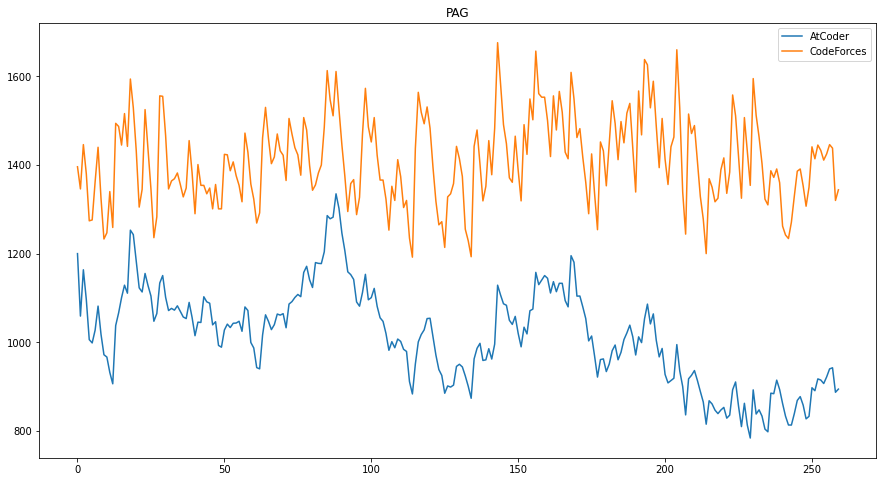

In [10]:
results.plot_user("PAG", verbose=True)

## Testing parameters

In [7]:
g_bases = np.linspace(1.3, 8, 10)
g_bases = np.linspace(8.1, 13, 3)
g_power_divs = np.linspace(2, 1000, 10)
g_power_divs = np.linspace(1100, 1500, 3)
binsearch_bases = np.linspace(1.3, 10, 10)
binsearch_bases = np.linspace(10.5, 13, 3)
binsearch_power_divs = np.linspace(200, 1000, 10)
binsearch_power_divs = np.linspace(1100, 1500, 3)
decays = np.linspace(0.5, 0.95, 10)
decays = np.linspace(0.95, 0.99, 3)

mult = len(g_bases) + len(g_power_divs) + len(binsearch_bases) + len(binsearch_power_divs) + len(decays)
one_instance = 4 * 60 + 7
all_instances = one_instance * mult
print("Estimated time: %02dh %02dm %02.2fs" % (all_instances // 3600, all_instances % 3600 // 60, all_instances % 60))

Estimated time: 01h 01m 45.00s


In [8]:
consider = -1
save_file = f"save{consider}.pickle"

if os.path.exists(save_file):
    print("Loading file in ...")
    with open(save_file, "rb") as infile:
        all_results = pickle.load(infile)
    print("File loaded.")
else:
    all_results = {
        "g_base": {},
        "g_power_div": {},
        "binsearch_base": {},
        "binsearch_power_div": {},
        "decay": {}
    }

# all_results["g_base"][1.3][0]["linear_err"] gives contest id -> error mapping
#                            0 because atcoder_calculate returns tuple (errors, results)

err_fun = [linear_err, sqrt_err, squared_err]

Loading file in ...
File loaded.


In [16]:
for g_base in g_bases[1:]:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=err_fun,
        g_base=g_base, g_power_div=800, binsearch_base=6, binsearch_power_div=400, decay=0.9,
        consider=consider, verbose=True)
    all_results["g_base"][g_base] = (errors, results)
    
#     with open(save_file, "wb") as outfile:
#         pickle.dump(all_results, outfile)

Standings left: 989
Standings left: 988
Standings left: 987
Standings left: 986
Standings left: 985
Standings left: 984
Standings left: 983
Standings left: 982
Standings left: 981
Standings left: 980
Standings left: 979
Standings left: 978
Standings left: 977
Standings left: 976
Standings left: 975
Standings left: 974
Standings left: 973
Standings left: 972
Standings left: 971
Standings left: 970
Standings left: 969
Standings left: 968
Standings left: 967
Standings left: 966
Standings left: 965
Standings left: 964
Standings left: 963
Standings left: 962
Standings left: 961
Standings left: 960
Standings left: 959
Standings left: 958
Standings left: 957
Standings left: 956
Standings left: 955
Standings left: 954
Standings left: 953
Standings left: 952
Standings left: 951
Standings left: 950
Standings left: 949
Standings left: 948
Standings left: 947
Standings left: 946
Standings left: 945
Standings left: 944
Standings left: 943
Standings left: 942
Standings left: 941
Standings left: 940


Standings left: 573
Standings left: 572
Standings left: 571
Standings left: 570
Standings left: 569
Standings left: 568
Standings left: 567
Standings left: 566
Standings left: 565
Standings left: 564
Standings left: 563
Standings left: 562
Standings left: 561
Standings left: 560
Standings left: 559
Standings left: 558
Standings left: 557
Standings left: 556
Standings left: 555
Standings left: 554
Standings left: 553
Standings left: 552
Standings left: 551
Standings left: 550
Standings left: 549
Standings left: 548
Standings left: 547
Standings left: 546
Standings left: 545
Standings left: 544
Standings left: 543
Standings left: 542
Standings left: 541
Standings left: 540
Standings left: 539
Standings left: 538
Standings left: 537
Standings left: 536
Standings left: 535
Standings left: 534
Standings left: 533
Standings left: 532
Standings left: 531
Standings left: 530
Standings left: 529
Standings left: 528
Standings left: 527
Standings left: 526
Standings left: 525
Standings left: 524


Standings left: 160
Standings left: 159
Standings left: 158
Standings left: 157
Standings left: 156
Standings left: 155
Standings left: 154
Standings left: 153
Standings left: 152
Standings left: 151
Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116
Standings left: 115
Standings left: 114
Standings left: 113
Standings left: 112
Standings left: 111


Standings left: 733
Standings left: 732
Standings left: 731
Standings left: 730
Standings left: 729
Standings left: 728
Standings left: 727
Standings left: 726
Standings left: 725
Standings left: 724
Standings left: 723
Standings left: 722
Standings left: 721
Standings left: 720
Standings left: 719
Standings left: 718
Standings left: 717
Standings left: 716
Standings left: 715
Standings left: 714
Standings left: 713
Standings left: 712
Standings left: 711
Standings left: 710
Standings left: 709
Standings left: 708
Standings left: 707
Standings left: 706
Standings left: 705
Standings left: 704
Standings left: 703
Standings left: 702
Standings left: 701
Standings left: 700
Standings left: 699
Standings left: 698
Standings left: 697
Standings left: 696
Standings left: 695
Standings left: 694
Standings left: 693
Standings left: 692
Standings left: 691
Standings left: 690
Standings left: 689
Standings left: 688
Standings left: 687
Standings left: 686
Standings left: 685
Standings left: 684


Standings left: 321
Standings left: 320
Standings left: 319
Standings left: 318
Standings left: 317
Standings left: 316
Standings left: 315
Standings left: 314
Standings left: 313
Standings left: 312
Standings left: 311
Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295
Standings left: 294
Standings left: 293
Standings left: 292
Standings left: 291
Standings left: 290
Standings left: 289
Standings left: 288
Standings left: 287
Standings left: 286
Standings left: 285
Standings left: 284
Standings left: 283
Standings left: 282
Standings left: 281
Standings left: 280
Standings left: 279
Standings left: 278
Standings left: 277
Standings left: 276
Standings left: 275
Standings left: 274
Standings left: 273
Standings left: 272


In [17]:
for g_power_div in g_power_divs:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=err_fun,
        g_base=2, g_power_div=g_power_div, binsearch_base=6, binsearch_power_div=400, decay=0.9,
        consider=consider, verbose=True)
    all_results["g_power_div"][g_power_div] = (errors, results)
    
#     with open(save_file, "wb") as outfile:
#         pickle.dump(all_results, outfile)

Standings left: 989
Standings left: 988
Standings left: 987
Standings left: 986
Standings left: 985
Standings left: 984
Standings left: 983
Standings left: 982
Standings left: 981
Standings left: 980
Standings left: 979
Standings left: 978
Standings left: 977
Standings left: 976
Standings left: 975
Standings left: 974
Standings left: 973
Standings left: 972
Standings left: 971
Standings left: 970
Standings left: 969
Standings left: 968
Standings left: 967
Standings left: 966
Standings left: 965
Standings left: 964
Standings left: 963
Standings left: 962
Standings left: 961
Standings left: 960
Standings left: 959
Standings left: 958
Standings left: 957
Standings left: 956
Standings left: 955
Standings left: 954
Standings left: 953
Standings left: 952
Standings left: 951
Standings left: 950
Standings left: 949
Standings left: 948
Standings left: 947
Standings left: 946
Standings left: 945
Standings left: 944
Standings left: 943
Standings left: 942
Standings left: 941
Standings left: 940


Standings left: 572
Standings left: 571
Standings left: 570
Standings left: 569
Standings left: 568
Standings left: 567
Standings left: 566
Standings left: 565
Standings left: 564
Standings left: 563
Standings left: 562
Standings left: 561
Standings left: 560
Standings left: 559
Standings left: 558
Standings left: 557
Standings left: 556
Standings left: 555
Standings left: 554
Standings left: 553
Standings left: 552
Standings left: 551
Standings left: 550
Standings left: 549
Standings left: 548
Standings left: 547
Standings left: 546
Standings left: 545
Standings left: 544
Standings left: 543
Standings left: 542
Standings left: 541
Standings left: 540
Standings left: 539
Standings left: 538
Standings left: 537
Standings left: 536
Standings left: 535
Standings left: 534
Standings left: 533
Standings left: 532
Standings left: 531
Standings left: 530
Standings left: 529
Standings left: 528
Standings left: 527
Standings left: 526
Standings left: 525
Standings left: 524
Standings left: 523


Standings left: 160
Standings left: 159
Standings left: 158
Standings left: 157
Standings left: 156
Standings left: 155
Standings left: 154
Standings left: 153
Standings left: 152
Standings left: 151
Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116
Standings left: 115
Standings left: 114
Standings left: 113
Standings left: 112
Standings left: 111


Standings left: 729
Standings left: 728
Standings left: 727
Standings left: 726
Standings left: 725
Standings left: 724
Standings left: 723
Standings left: 722
Standings left: 721
Standings left: 720
Standings left: 719
Standings left: 718
Standings left: 717
Standings left: 716
Standings left: 715
Standings left: 714
Standings left: 713
Standings left: 712
Standings left: 711
Standings left: 710
Standings left: 709
Standings left: 708
Standings left: 707
Standings left: 706
Standings left: 705
Standings left: 704
Standings left: 703
Standings left: 702
Standings left: 701
Standings left: 700
Standings left: 699
Standings left: 698
Standings left: 697
Standings left: 696
Standings left: 695
Standings left: 694
Standings left: 693
Standings left: 692
Standings left: 691
Standings left: 690
Standings left: 689
Standings left: 688
Standings left: 687
Standings left: 686
Standings left: 685
Standings left: 684
Standings left: 683
Standings left: 682
Standings left: 681
Standings left: 680


Standings left: 317
Standings left: 316
Standings left: 315
Standings left: 314
Standings left: 313
Standings left: 312
Standings left: 311
Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295
Standings left: 294
Standings left: 293
Standings left: 292
Standings left: 291
Standings left: 290
Standings left: 289
Standings left: 288
Standings left: 287
Standings left: 286
Standings left: 285
Standings left: 284
Standings left: 283
Standings left: 282
Standings left: 281
Standings left: 280
Standings left: 279
Standings left: 278
Standings left: 277
Standings left: 276
Standings left: 275
Standings left: 274
Standings left: 273
Standings left: 272
Standings left: 271
Standings left: 270
Standings left: 269
Standings left: 268


Standings left: 886
Standings left: 885
Standings left: 884
Standings left: 883
Standings left: 882
Standings left: 881
Standings left: 880
Standings left: 879
Standings left: 878
Standings left: 877
Standings left: 876
Standings left: 875
Standings left: 874
Standings left: 873
Standings left: 872
Standings left: 871
Standings left: 870
Standings left: 869
Standings left: 868
Standings left: 867
Standings left: 866
Standings left: 865
Standings left: 864
Standings left: 863
Standings left: 862
Standings left: 861
Standings left: 860
Standings left: 859
Standings left: 858
Standings left: 857
Standings left: 856
Standings left: 855
Standings left: 854
Standings left: 853
Standings left: 852
Standings left: 851
Standings left: 850
Standings left: 849
Standings left: 848
Standings left: 847
Standings left: 846
Standings left: 845
Standings left: 844
Standings left: 843
Standings left: 842
Standings left: 841
Standings left: 840
Standings left: 839
Standings left: 838
Standings left: 837


Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454
Standings left: 453
Standings left: 452
Standings left: 451
Standings left: 450
Standings left: 449
Standings left: 448
Standings left: 447
Standings left: 446
Standings left: 445
Standings left: 444
Standings left: 443
Standings left: 442
Standings left: 441
Standings left: 440
Standings left: 439
Standings left: 438
Standings left: 437
Standings left: 436
Standings left: 435
Standings left: 434
Standings left: 433
Standings left: 432
Standings left: 431
Standings left: 430
Standings left: 429
Standings left: 428
Standings left: 427
Standings left: 426
Standings left: 425
Standings left: 424
Standings left: 423
Standings left: 422


Standings left: 51
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings left: 36
Standings left: 35
Standings left: 34
Standings left: 33
Standings left: 32
Standings left: 31
Standings left: 30
Standings left: 29
Standings left: 28
Standings left: 27
Standings left: 26
Standings left: 25
Standings left: 24
Standings left: 23
Standings left: 22
Standings left: 21
Standings left: 20
Standings left: 19
Standings left: 18
Standings left: 17
Standings left: 16
Standings left: 15
Standings left: 14
Standings left: 13
Standings left: 12
Standings left: 11
Standings left: 10
Standings left: 9
Standings left: 8
Standings left: 7
Standings left: 6
Standings left: 5
Standings left: 4
Standings left: 3
Standings left: 2
Standings left: 1
Calculated in 04m 6.20s


In [18]:
for binsearch_base in binsearch_bases:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=err_fun,
        g_base=2, g_power_div=800, binsearch_base=binsearch_base, binsearch_power_div=400, decay=0.9,
        consider=consider, verbose=True)
    all_results["binsearch_base"][binsearch_base] = (errors, results)
    
#     with open(save_file, "wb") as outfile:
#         pickle.dump(all_results, outfile)

Standings left: 989
Standings left: 988
Standings left: 987
Standings left: 986
Standings left: 985
Standings left: 984
Standings left: 983
Standings left: 982
Standings left: 981
Standings left: 980
Standings left: 979
Standings left: 978
Standings left: 977
Standings left: 976
Standings left: 975
Standings left: 974
Standings left: 973
Standings left: 972
Standings left: 971
Standings left: 970
Standings left: 969
Standings left: 968
Standings left: 967
Standings left: 966
Standings left: 965
Standings left: 964
Standings left: 963
Standings left: 962
Standings left: 961
Standings left: 960
Standings left: 959
Standings left: 958
Standings left: 957
Standings left: 956
Standings left: 955
Standings left: 954
Standings left: 953
Standings left: 952
Standings left: 951
Standings left: 950
Standings left: 949
Standings left: 948
Standings left: 947
Standings left: 946
Standings left: 945
Standings left: 944
Standings left: 943
Standings left: 942
Standings left: 941
Standings left: 940


Standings left: 579
Standings left: 578
Standings left: 577
Standings left: 576
Standings left: 575
Standings left: 574
Standings left: 573
Standings left: 572
Standings left: 571
Standings left: 570
Standings left: 569
Standings left: 568
Standings left: 567
Standings left: 566
Standings left: 565
Standings left: 564
Standings left: 563
Standings left: 562
Standings left: 561
Standings left: 560
Standings left: 559
Standings left: 558
Standings left: 557
Standings left: 556
Standings left: 555
Standings left: 554
Standings left: 553
Standings left: 552
Standings left: 551
Standings left: 550
Standings left: 549
Standings left: 548
Standings left: 547
Standings left: 546
Standings left: 545
Standings left: 544
Standings left: 543
Standings left: 542
Standings left: 541
Standings left: 540
Standings left: 539
Standings left: 538
Standings left: 537
Standings left: 536
Standings left: 535
Standings left: 534
Standings left: 533
Standings left: 532
Standings left: 531
Standings left: 530


Standings left: 165
Standings left: 164
Standings left: 163
Standings left: 162
Standings left: 161
Standings left: 160
Standings left: 159
Standings left: 158
Standings left: 157
Standings left: 156
Standings left: 155
Standings left: 154
Standings left: 153
Standings left: 152
Standings left: 151
Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116


Standings left: 734
Standings left: 733
Standings left: 732
Standings left: 731
Standings left: 730
Standings left: 729
Standings left: 728
Standings left: 727
Standings left: 726
Standings left: 725
Standings left: 724
Standings left: 723
Standings left: 722
Standings left: 721
Standings left: 720
Standings left: 719
Standings left: 718
Standings left: 717
Standings left: 716
Standings left: 715
Standings left: 714
Standings left: 713
Standings left: 712
Standings left: 711
Standings left: 710
Standings left: 709
Standings left: 708
Standings left: 707
Standings left: 706
Standings left: 705
Standings left: 704
Standings left: 703
Standings left: 702
Standings left: 701
Standings left: 700
Standings left: 699
Standings left: 698
Standings left: 697
Standings left: 696
Standings left: 695
Standings left: 694
Standings left: 693
Standings left: 692
Standings left: 691
Standings left: 690
Standings left: 689
Standings left: 688
Standings left: 687
Standings left: 686
Standings left: 685


Standings left: 322
Standings left: 321
Standings left: 320
Standings left: 319
Standings left: 318
Standings left: 317
Standings left: 316
Standings left: 315
Standings left: 314
Standings left: 313
Standings left: 312
Standings left: 311
Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295
Standings left: 294
Standings left: 293
Standings left: 292
Standings left: 291
Standings left: 290
Standings left: 289
Standings left: 288
Standings left: 287
Standings left: 286
Standings left: 285
Standings left: 284
Standings left: 283
Standings left: 282
Standings left: 281
Standings left: 280
Standings left: 279
Standings left: 278
Standings left: 277
Standings left: 276
Standings left: 275
Standings left: 274
Standings left: 273


Standings left: 897
Standings left: 896
Standings left: 895
Standings left: 894
Standings left: 893
Standings left: 892
Standings left: 891
Standings left: 890
Standings left: 889
Standings left: 888
Standings left: 887
Standings left: 886
Standings left: 885
Standings left: 884
Standings left: 883
Standings left: 882
Standings left: 881
Standings left: 880
Standings left: 879
Standings left: 878
Standings left: 877
Standings left: 876
Standings left: 875
Standings left: 874
Standings left: 873
Standings left: 872
Standings left: 871
Standings left: 870
Standings left: 869
Standings left: 868
Standings left: 867
Standings left: 866
Standings left: 865
Standings left: 864
Standings left: 863
Standings left: 862
Standings left: 861
Standings left: 860
Standings left: 859
Standings left: 858
Standings left: 857
Standings left: 856
Standings left: 855
Standings left: 854
Standings left: 853
Standings left: 852
Standings left: 851
Standings left: 850
Standings left: 849
Standings left: 848


Standings left: 487
Standings left: 486
Standings left: 485
Standings left: 484
Standings left: 483
Standings left: 482
Standings left: 481
Standings left: 480
Standings left: 479
Standings left: 478
Standings left: 477
Standings left: 476
Standings left: 475
Standings left: 474
Standings left: 473
Standings left: 472
Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454
Standings left: 453
Standings left: 452
Standings left: 451
Standings left: 450
Standings left: 449
Standings left: 448
Standings left: 447
Standings left: 446
Standings left: 445
Standings left: 444
Standings left: 443
Standings left: 442
Standings left: 441
Standings left: 440
Standings left: 439
Standings left: 438


Standings left: 76
Standings left: 75
Standings left: 74
Standings left: 73
Standings left: 72
Standings left: 71
Standings left: 70
Standings left: 69
Standings left: 68
Standings left: 67
Standings left: 66
Standings left: 65
Standings left: 64
Standings left: 63
Standings left: 62
Standings left: 61
Standings left: 60
Standings left: 59
Standings left: 58
Standings left: 57
Standings left: 56
Standings left: 55
Standings left: 54
Standings left: 53
Standings left: 52
Standings left: 51
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings left: 36
Standings left: 35
Standings left: 34
Standings left: 33
Standings left: 32
Standings left: 31
Standings left: 30
Standings left: 29
Standings left: 28
Standings left: 27
Standings left: 26
Standings left: 25
Standings le

In [19]:
for binsearch_power_div in binsearch_power_divs:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=err_fun,
        g_base=2, g_power_div=800, binsearch_base=6, binsearch_power_div=binsearch_power_div, decay=0.9,
        consider=consider, verbose=True)
    all_results["binsearch_power_div"][binsearch_power_div] = (errors, results)
    
#     with open("save.pickle", "wb") as outfile:
#         pickle.dump(all_results, outfile)

Standings left: 989
Standings left: 988
Standings left: 987
Standings left: 986
Standings left: 985
Standings left: 984
Standings left: 983
Standings left: 982
Standings left: 981
Standings left: 980
Standings left: 979
Standings left: 978
Standings left: 977
Standings left: 976
Standings left: 975
Standings left: 974
Standings left: 973
Standings left: 972
Standings left: 971
Standings left: 970
Standings left: 969
Standings left: 968
Standings left: 967
Standings left: 966
Standings left: 965
Standings left: 964
Standings left: 963
Standings left: 962
Standings left: 961
Standings left: 960
Standings left: 959
Standings left: 958
Standings left: 957
Standings left: 956
Standings left: 955
Standings left: 954
Standings left: 953
Standings left: 952
Standings left: 951
Standings left: 950
Standings left: 949
Standings left: 948
Standings left: 947
Standings left: 946
Standings left: 945
Standings left: 944
Standings left: 943
Standings left: 942
Standings left: 941
Standings left: 940


Standings left: 577
Standings left: 576
Standings left: 575
Standings left: 574
Standings left: 573
Standings left: 572
Standings left: 571
Standings left: 570
Standings left: 569
Standings left: 568
Standings left: 567
Standings left: 566
Standings left: 565
Standings left: 564
Standings left: 563
Standings left: 562
Standings left: 561
Standings left: 560
Standings left: 559
Standings left: 558
Standings left: 557
Standings left: 556
Standings left: 555
Standings left: 554
Standings left: 553
Standings left: 552
Standings left: 551
Standings left: 550
Standings left: 549
Standings left: 548
Standings left: 547
Standings left: 546
Standings left: 545
Standings left: 544
Standings left: 543
Standings left: 542
Standings left: 541
Standings left: 540
Standings left: 539
Standings left: 538
Standings left: 537
Standings left: 536
Standings left: 535
Standings left: 534
Standings left: 533
Standings left: 532
Standings left: 531
Standings left: 530
Standings left: 529
Standings left: 528


Standings left: 165
Standings left: 164
Standings left: 163
Standings left: 162
Standings left: 161
Standings left: 160
Standings left: 159
Standings left: 158
Standings left: 157
Standings left: 156
Standings left: 155
Standings left: 154
Standings left: 153
Standings left: 152
Standings left: 151
Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116


Standings left: 735
Standings left: 734
Standings left: 733
Standings left: 732
Standings left: 731
Standings left: 730
Standings left: 729
Standings left: 728
Standings left: 727
Standings left: 726
Standings left: 725
Standings left: 724
Standings left: 723
Standings left: 722
Standings left: 721
Standings left: 720
Standings left: 719
Standings left: 718
Standings left: 717
Standings left: 716
Standings left: 715
Standings left: 714
Standings left: 713
Standings left: 712
Standings left: 711
Standings left: 710
Standings left: 709
Standings left: 708
Standings left: 707
Standings left: 706
Standings left: 705
Standings left: 704
Standings left: 703
Standings left: 702
Standings left: 701
Standings left: 700
Standings left: 699
Standings left: 698
Standings left: 697
Standings left: 696
Standings left: 695
Standings left: 694
Standings left: 693
Standings left: 692
Standings left: 691
Standings left: 690
Standings left: 689
Standings left: 688
Standings left: 687
Standings left: 686


Standings left: 322
Standings left: 321
Standings left: 320
Standings left: 319
Standings left: 318
Standings left: 317
Standings left: 316
Standings left: 315
Standings left: 314
Standings left: 313
Standings left: 312
Standings left: 311
Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295
Standings left: 294
Standings left: 293
Standings left: 292
Standings left: 291
Standings left: 290
Standings left: 289
Standings left: 288
Standings left: 287
Standings left: 286
Standings left: 285
Standings left: 284
Standings left: 283
Standings left: 282
Standings left: 281
Standings left: 280
Standings left: 279
Standings left: 278
Standings left: 277
Standings left: 276
Standings left: 275
Standings left: 274
Standings left: 273


Standings left: 897
Standings left: 896
Standings left: 895
Standings left: 894
Standings left: 893
Standings left: 892
Standings left: 891
Standings left: 890
Standings left: 889
Standings left: 888
Standings left: 887
Standings left: 886
Standings left: 885
Standings left: 884
Standings left: 883
Standings left: 882
Standings left: 881
Standings left: 880
Standings left: 879
Standings left: 878
Standings left: 877
Standings left: 876
Standings left: 875
Standings left: 874
Standings left: 873
Standings left: 872
Standings left: 871
Standings left: 870
Standings left: 869
Standings left: 868
Standings left: 867
Standings left: 866
Standings left: 865
Standings left: 864
Standings left: 863
Standings left: 862
Standings left: 861
Standings left: 860
Standings left: 859
Standings left: 858
Standings left: 857
Standings left: 856
Standings left: 855
Standings left: 854
Standings left: 853
Standings left: 852
Standings left: 851
Standings left: 850
Standings left: 849
Standings left: 848


Standings left: 479
Standings left: 478
Standings left: 477
Standings left: 476
Standings left: 475
Standings left: 474
Standings left: 473
Standings left: 472
Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454
Standings left: 453
Standings left: 452
Standings left: 451
Standings left: 450
Standings left: 449
Standings left: 448
Standings left: 447
Standings left: 446
Standings left: 445
Standings left: 444
Standings left: 443
Standings left: 442
Standings left: 441
Standings left: 440
Standings left: 439
Standings left: 438
Standings left: 437
Standings left: 436
Standings left: 435
Standings left: 434
Standings left: 433
Standings left: 432
Standings left: 431
Standings left: 430


Standings left: 67
Standings left: 66
Standings left: 65
Standings left: 64
Standings left: 63
Standings left: 62
Standings left: 61
Standings left: 60
Standings left: 59
Standings left: 58
Standings left: 57
Standings left: 56
Standings left: 55
Standings left: 54
Standings left: 53
Standings left: 52
Standings left: 51
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings left: 36
Standings left: 35
Standings left: 34
Standings left: 33
Standings left: 32
Standings left: 31
Standings left: 30
Standings left: 29
Standings left: 28
Standings left: 27
Standings left: 26
Standings left: 25
Standings left: 24
Standings left: 23
Standings left: 22
Standings left: 21
Standings left: 20
Standings left: 19
Standings left: 18
Standings left: 17
Standings left: 16
Standings le

In [20]:
for decay in decays:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=err_fun,
        g_base=2, g_power_div=800, binsearch_base=6, binsearch_power_div=400, decay=decay,
        consider=consider, verbose=True)
    all_results["decay"][decay] = (errors, results)
    
#     with open(save_file, "wb") as outfile:
#         pickle.dump(all_results, outfile)

Standings left: 989
Standings left: 988
Standings left: 987
Standings left: 986
Standings left: 985
Standings left: 984
Standings left: 983
Standings left: 982
Standings left: 981
Standings left: 980
Standings left: 979
Standings left: 978
Standings left: 977
Standings left: 976
Standings left: 975
Standings left: 974
Standings left: 973
Standings left: 972
Standings left: 971
Standings left: 970
Standings left: 969
Standings left: 968
Standings left: 967
Standings left: 966
Standings left: 965
Standings left: 964
Standings left: 963
Standings left: 962
Standings left: 961
Standings left: 960
Standings left: 959
Standings left: 958
Standings left: 957
Standings left: 956
Standings left: 955
Standings left: 954
Standings left: 953
Standings left: 952
Standings left: 951
Standings left: 950
Standings left: 949
Standings left: 948
Standings left: 947
Standings left: 946
Standings left: 945
Standings left: 944
Standings left: 943
Standings left: 942
Standings left: 941
Standings left: 940


Standings left: 579
Standings left: 578
Standings left: 577
Standings left: 576
Standings left: 575
Standings left: 574
Standings left: 573
Standings left: 572
Standings left: 571
Standings left: 570
Standings left: 569
Standings left: 568
Standings left: 567
Standings left: 566
Standings left: 565
Standings left: 564
Standings left: 563
Standings left: 562
Standings left: 561
Standings left: 560
Standings left: 559
Standings left: 558
Standings left: 557
Standings left: 556
Standings left: 555
Standings left: 554
Standings left: 553
Standings left: 552
Standings left: 551
Standings left: 550
Standings left: 549
Standings left: 548
Standings left: 547
Standings left: 546
Standings left: 545
Standings left: 544
Standings left: 543
Standings left: 542
Standings left: 541
Standings left: 540
Standings left: 539
Standings left: 538
Standings left: 537
Standings left: 536
Standings left: 535
Standings left: 534
Standings left: 533
Standings left: 532
Standings left: 531
Standings left: 530


Standings left: 167
Standings left: 166
Standings left: 165
Standings left: 164
Standings left: 163
Standings left: 162
Standings left: 161
Standings left: 160
Standings left: 159
Standings left: 158
Standings left: 157
Standings left: 156
Standings left: 155
Standings left: 154
Standings left: 153
Standings left: 152
Standings left: 151
Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118


Standings left: 739
Standings left: 738
Standings left: 737
Standings left: 736
Standings left: 735
Standings left: 734
Standings left: 733
Standings left: 732
Standings left: 731
Standings left: 730
Standings left: 729
Standings left: 728
Standings left: 727
Standings left: 726
Standings left: 725
Standings left: 724
Standings left: 723
Standings left: 722
Standings left: 721
Standings left: 720
Standings left: 719
Standings left: 718
Standings left: 717
Standings left: 716
Standings left: 715
Standings left: 714
Standings left: 713
Standings left: 712
Standings left: 711
Standings left: 710
Standings left: 709
Standings left: 708
Standings left: 707
Standings left: 706
Standings left: 705
Standings left: 704
Standings left: 703
Standings left: 702
Standings left: 701
Standings left: 700
Standings left: 699
Standings left: 698
Standings left: 697
Standings left: 696
Standings left: 695
Standings left: 694
Standings left: 693
Standings left: 692
Standings left: 691
Standings left: 690


Standings left: 322
Standings left: 321
Standings left: 320
Standings left: 319
Standings left: 318
Standings left: 317
Standings left: 316
Standings left: 315
Standings left: 314
Standings left: 313
Standings left: 312
Standings left: 311
Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295
Standings left: 294
Standings left: 293
Standings left: 292
Standings left: 291
Standings left: 290
Standings left: 289
Standings left: 288
Standings left: 287
Standings left: 286
Standings left: 285
Standings left: 284
Standings left: 283
Standings left: 282
Standings left: 281
Standings left: 280
Standings left: 279
Standings left: 278
Standings left: 277
Standings left: 276
Standings left: 275
Standings left: 274
Standings left: 273


Standings left: 886
Standings left: 885
Standings left: 884
Standings left: 883
Standings left: 882
Standings left: 881
Standings left: 880
Standings left: 879
Standings left: 878
Standings left: 877
Standings left: 876
Standings left: 875
Standings left: 874
Standings left: 873
Standings left: 872
Standings left: 871
Standings left: 870
Standings left: 869
Standings left: 868
Standings left: 867
Standings left: 866
Standings left: 865
Standings left: 864
Standings left: 863
Standings left: 862
Standings left: 861
Standings left: 860
Standings left: 859
Standings left: 858
Standings left: 857
Standings left: 856
Standings left: 855
Standings left: 854
Standings left: 853
Standings left: 852
Standings left: 851
Standings left: 850
Standings left: 849
Standings left: 848
Standings left: 847
Standings left: 846
Standings left: 845
Standings left: 844
Standings left: 843
Standings left: 842
Standings left: 841
Standings left: 840
Standings left: 839
Standings left: 838
Standings left: 837


Standings left: 473
Standings left: 472
Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454
Standings left: 453
Standings left: 452
Standings left: 451
Standings left: 450
Standings left: 449
Standings left: 448
Standings left: 447
Standings left: 446
Standings left: 445
Standings left: 444
Standings left: 443
Standings left: 442
Standings left: 441
Standings left: 440
Standings left: 439
Standings left: 438
Standings left: 437
Standings left: 436
Standings left: 435
Standings left: 434
Standings left: 433
Standings left: 432
Standings left: 431
Standings left: 430
Standings left: 429
Standings left: 428
Standings left: 427
Standings left: 426
Standings left: 425
Standings left: 424


Standings left: 57
Standings left: 56
Standings left: 55
Standings left: 54
Standings left: 53
Standings left: 52
Standings left: 51
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings left: 36
Standings left: 35
Standings left: 34
Standings left: 33
Standings left: 32
Standings left: 31
Standings left: 30
Standings left: 29
Standings left: 28
Standings left: 27
Standings left: 26
Standings left: 25
Standings left: 24
Standings left: 23
Standings left: 22
Standings left: 21
Standings left: 20
Standings left: 19
Standings left: 18
Standings left: 17
Standings left: 16
Standings left: 15
Standings left: 14
Standings left: 13
Standings left: 12
Standings left: 11
Standings left: 10
Standings left: 9
Standings left: 8
Standings left: 7
Standings left: 6
Standings left: 

### Looking at plots

In [21]:
def get_ratings(self, handle):
    handle_id = self.handle_to_id[handle]
    contest_cnt = self.user_contest_cnt[handle_id]
    user_offset = self.offsets[handle_id]
    assert contest_cnt == self.local_offsets[handle_id]

    perfs = self.perfs[user_offset:user_offset+contest_cnt]
    atcoder_ratings = self.ratings[user_offset:user_offset+contest_cnt]
    cf_ratings = self.get_cf_ratings(handle)
    xs = np.arange(contest_cnt)
    
    return xs, atcoder_ratings, cf_ratings

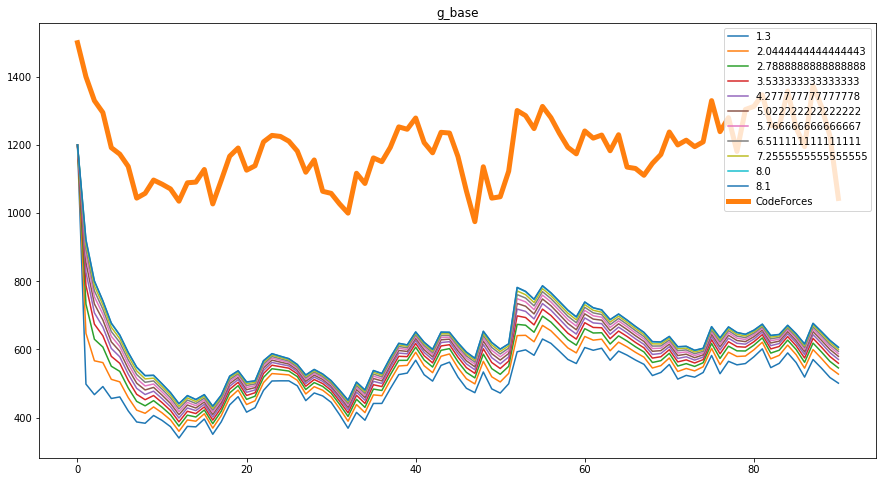

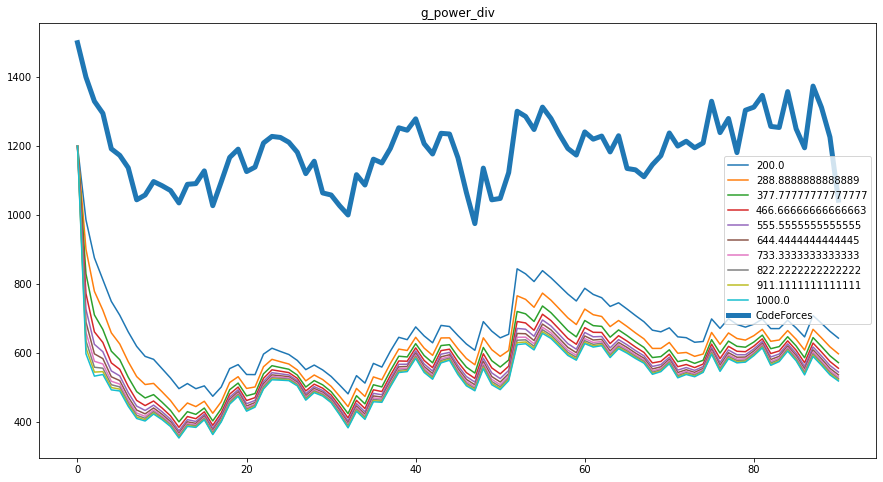

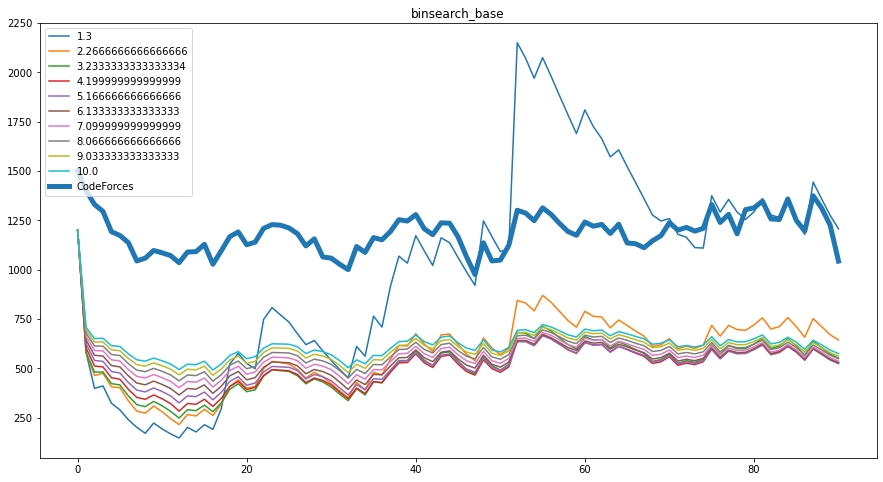

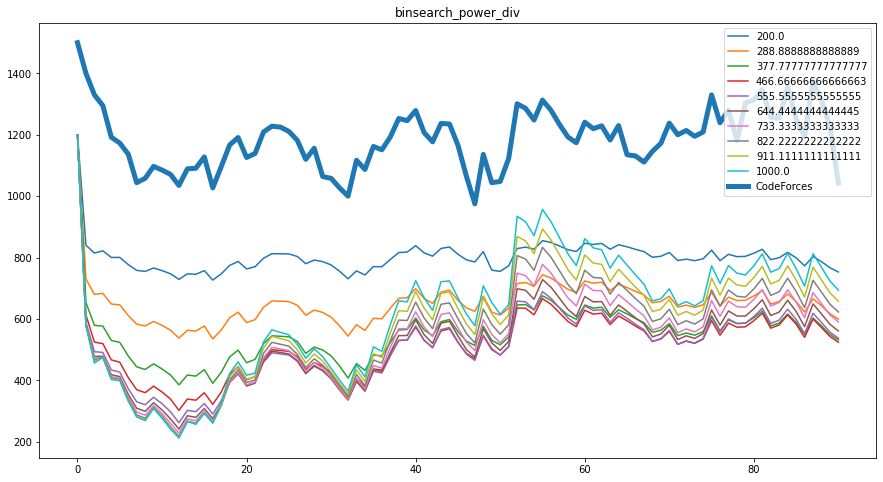

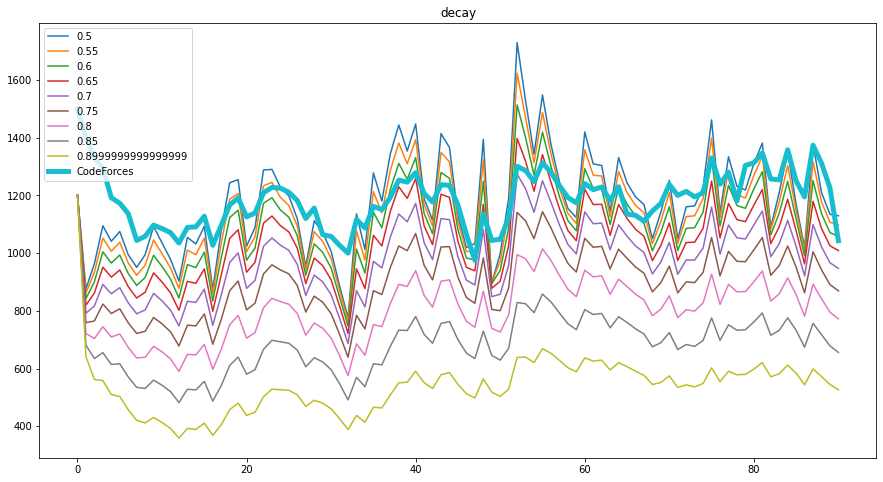

In [24]:
handle = all_results["g_base"][1.3][1].get_random_user(threshold=50)
for param_name, results in all_results.items():
    plt.figure(figsize=(15, 8))
    for value, (_, result) in results.items():
        xs, atcoder_ratings, cf_ratings = get_ratings(result, handle)
        plt.plot(xs, atcoder_ratings, label=str(value))
    plt.plot(xs, cf_ratings, label="CodeForces", linewidth=5)
    plt.title(param_name)
    plt.legend()
    plt.show()

### Load results

In [7]:
with open("save.pickle", "rb") as infile:
    all_results = pickle.load(infile)

### Plot results

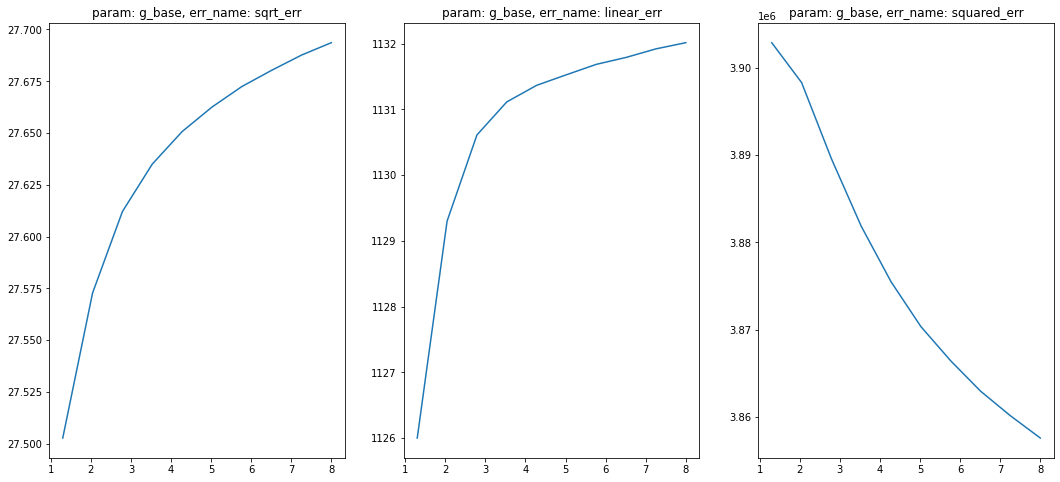

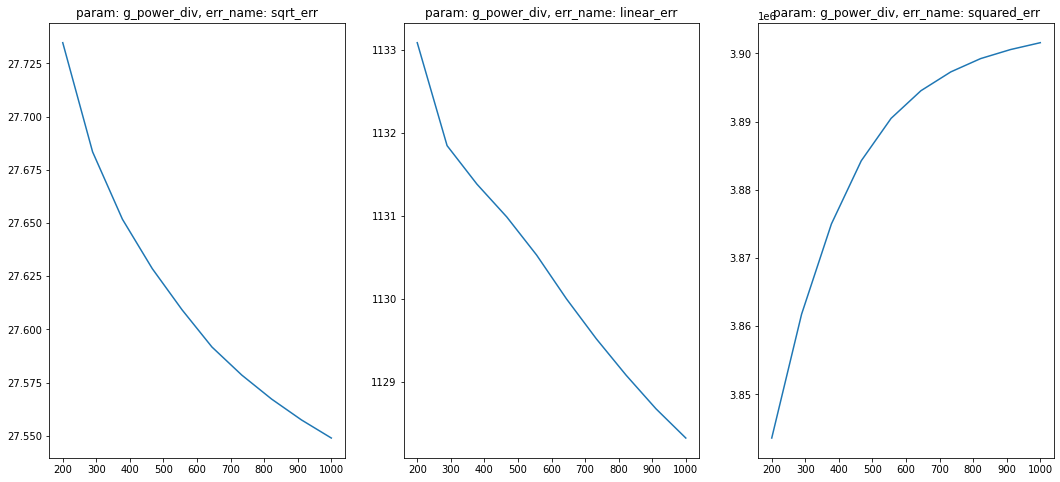

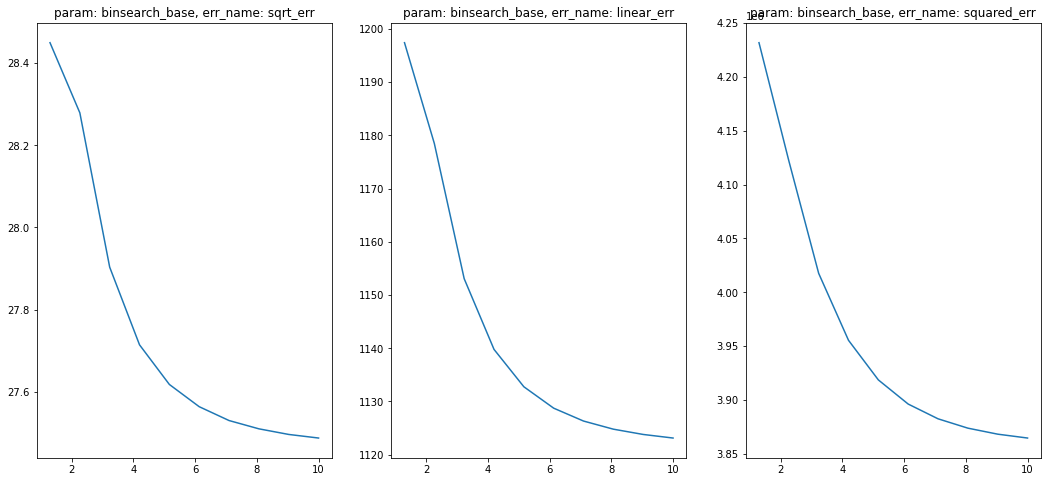

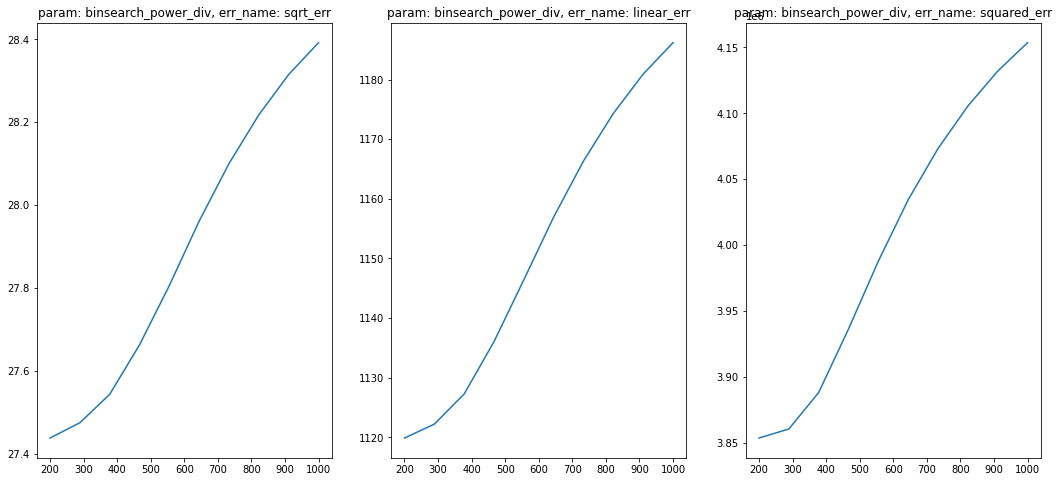

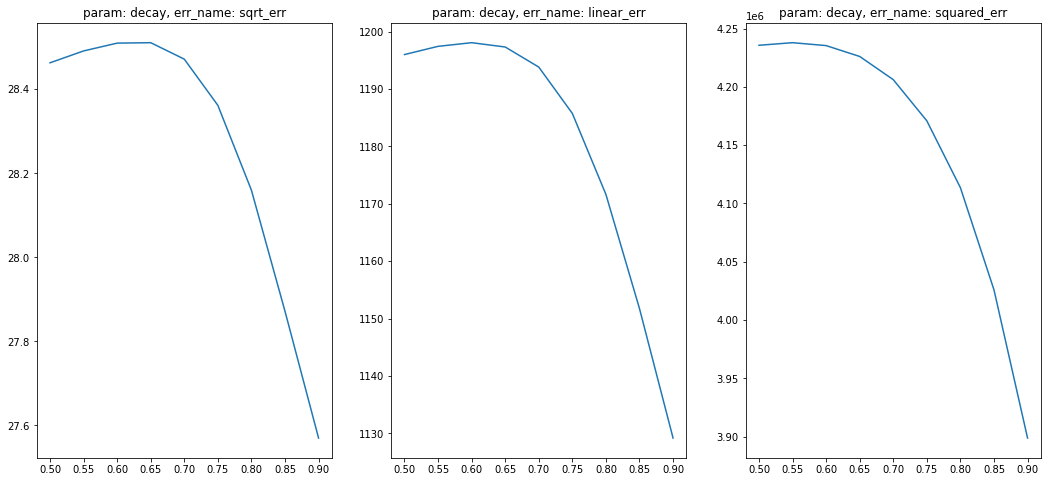

In [46]:
def get_ys(results, err_name):
    ys = []
    for val, (all_errors, _) in sorted(results.items(), key=lambda x: x[0]):
        errors = all_errors[err_name]
        vals = list(errors.values())
        ys.append(np.mean(vals))
    return ys
    
err_names = [err_f.__name__ for err_f in err_fun]
for param_name, results in all_results.items():
    fig, axs = plt.subplots(1, len(err_names), figsize=(18, 8))
    xs = sorted(list(results.keys()))
    for ax, err_name in zip(axs, err_names):
        ax.title.set_text(f"param: {param_name}, err_name: {err_name}")
        ys = get_ys(results, err_name)
        ax.plot(xs, ys)

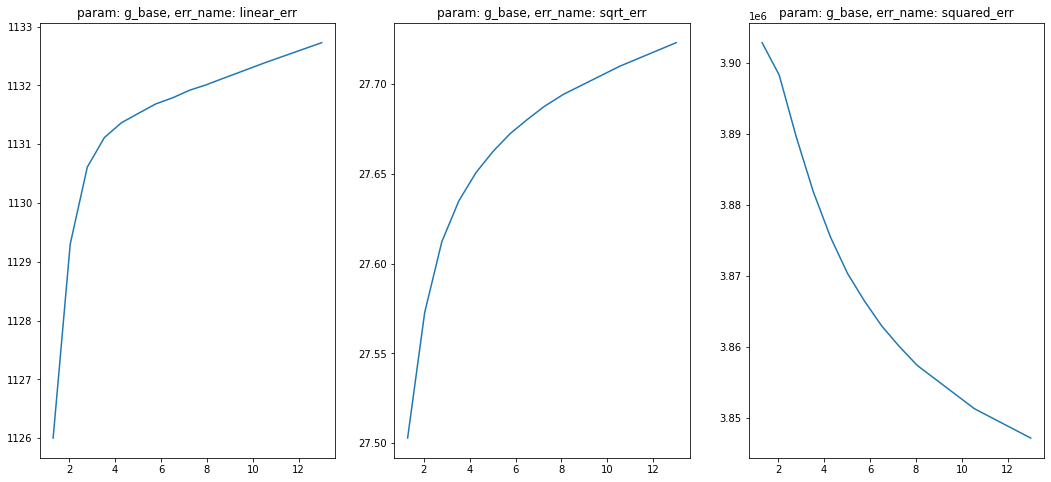

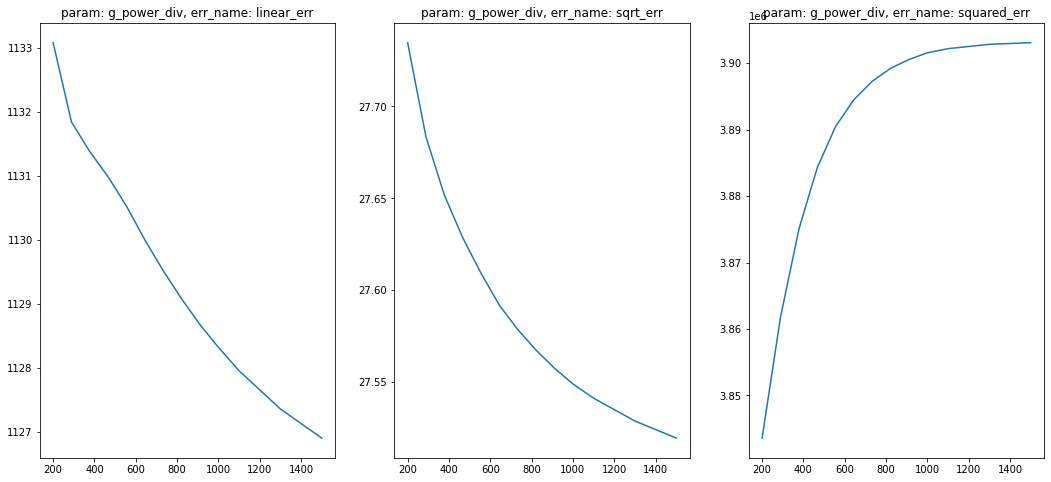

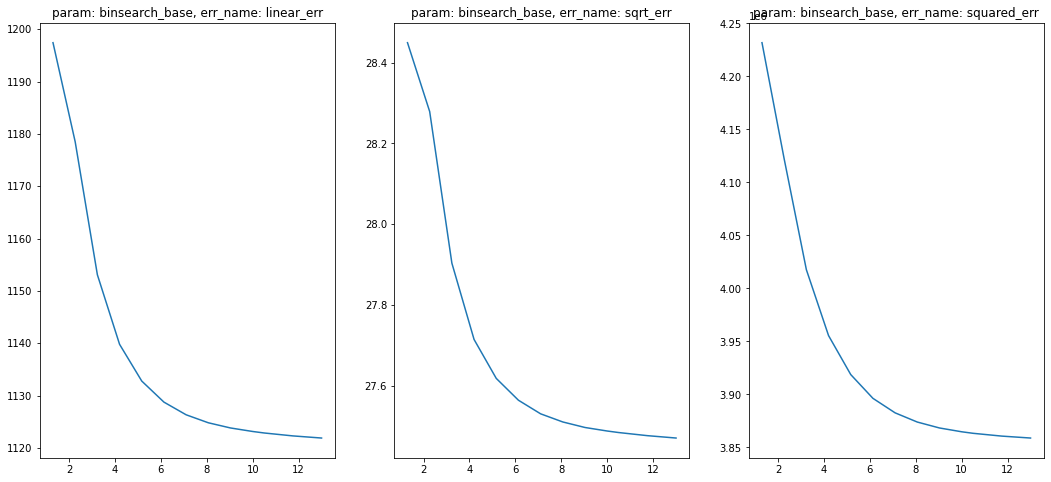

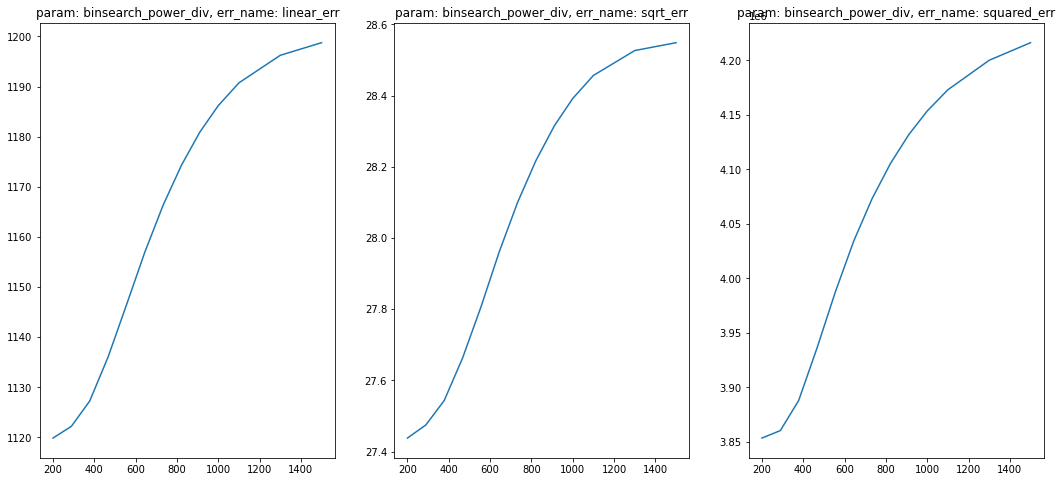

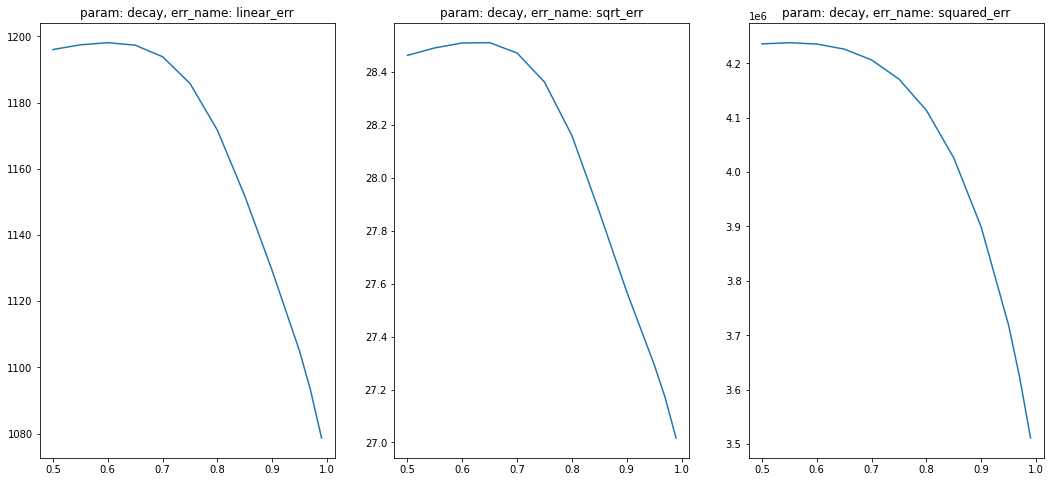

In [22]:
def get_ys(results, err_name):
    ys = []
    for val, (all_errors, _) in sorted(results.items(), key=lambda x: x[0]):
        errors = all_errors[err_name]
        vals = list(errors.values())
        ys.append(np.mean(vals))
    return ys
    
err_names = [err_f.__name__ for err_f in err_fun]
for param_name, results in all_results.items():
    fig, axs = plt.subplots(1, len(err_names), figsize=(18, 8))
    xs = sorted(list(results.keys()))
    for ax, err_name in zip(axs, err_names):
        ax.title.set_text(f"param: {param_name}, err_name: {err_name}")
        ys = get_ys(results, err_name)
        ax.plot(xs, ys)

## Testing parameters reduced

In [63]:
g_bases = np.linspace(1.3, 8, 10)
g_bases = np.linspace(8.1, 13, 3)
g_power_divs = np.linspace(2, 1000, 10)
g_power_divs = np.linspace(1100, 1500, 3)
binsearch_bases = np.linspace(1.3, 10, 10)
binsearch_bases = np.linspace(10.5, 13, 3)
binsearch_power_divs = np.linspace(200, 1000, 10)
binsearch_power_divs = np.linspace(1100, 1500, 3)
decays = np.linspace(0.5, 0.95, 10)
decays = np.linspace(0.95, 0.99, 3)

mult = len(g_bases) + len(g_power_divs) + len(binsearch_bases) + len(binsearch_power_divs) + len(decays)
one_instance = 4 * 60 + 7
all_instances = one_instance * mult
print("Estimated time: %02dh %02dm %02.2fs" % (all_instances // 3600, all_instances % 3600 // 60, all_instances % 60))

Estimated time: 01h 01m 45.00s


In [64]:
consider = 150
save_file = f"save_reduced{consider}.pickle"

if os.path.exists(save_file):
    print("Loading file in ...")
    with open(save_file, "rb") as infile:
        all_results = pickle.load(infile)
    print("File loaded.")
else:
    all_results = {
        "g_base": {},
        "g_power_div": {},
        "binsearch_base": {},
        "binsearch_power_div": {},
        "decay": {}
    }

# all_results["g_base"][1.3][0]["linear_err"] gives contest id -> error mapping
#                            0 because atcoder_calculate returns tuple (errors, results)

err_fun = [linear_err, sqrt_err, squared_err, log_err]

In [65]:
for g_base in g_bases:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=err_fun,
        g_base=g_base, g_power_div=800, binsearch_base=6, binsearch_power_div=400, decay=0.9,
        consider=consider, verbose=True)
    all_results["g_base"][g_base] = errors
    
#     with open(save_file, "wb") as outfile:
#         pickle.dump(all_results, outfile)

Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116
Standings left: 115
Standings left: 114
Standings left: 113
Standings left: 112
Standings left: 111
Standings left: 110
Standings left: 109
Standings left: 108
Standings left: 107
Standings left: 106
Standings left: 105
Standings left: 104
Standings left: 103
Standings left: 102
Standings left: 101


Standings left: 27
Standings left: 26
Standings left: 25
Standings left: 24
Standings left: 23
Standings left: 22
Standings left: 21
Standings left: 20
Standings left: 19
Standings left: 18
Standings left: 17
Standings left: 16
Standings left: 15
Standings left: 14
Standings left: 13
Standings left: 12
Standings left: 11
Standings left: 10
Standings left: 9
Standings left: 8
Standings left: 7
Standings left: 6
Standings left: 5
Standings left: 4
Standings left: 3
Standings left: 2
Standings left: 1
Calculated in 00m 4.22s


In [66]:
for g_power_div in g_power_divs:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=err_fun,
        g_base=2, g_power_div=g_power_div, binsearch_base=6, binsearch_power_div=400, decay=0.9,
        consider=consider, verbose=True)
    all_results["g_power_div"][g_power_div] = errors
    
#     with open(save_file, "wb") as outfile:
#         pickle.dump(all_results, outfile)

Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116
Standings left: 115
Standings left: 114
Standings left: 113
Standings left: 112
Standings left: 111
Standings left: 110
Standings left: 109
Standings left: 108
Standings left: 107
Standings left: 106
Standings left: 105
Standings left: 104
Standings left: 103
Standings left: 102
Standings left: 101


Standings left: 17
Standings left: 16
Standings left: 15
Standings left: 14
Standings left: 13
Standings left: 12
Standings left: 11
Standings left: 10
Standings left: 9
Standings left: 8
Standings left: 7
Standings left: 6
Standings left: 5
Standings left: 4
Standings left: 3
Standings left: 2
Standings left: 1
Calculated in 00m 4.20s


In [67]:
for binsearch_base in binsearch_bases:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=err_fun,
        g_base=2, g_power_div=800, binsearch_base=binsearch_base, binsearch_power_div=400, decay=0.9,
        consider=consider, verbose=True)
    all_results["binsearch_base"][binsearch_base] = errors
    
#     with open(save_file, "wb") as outfile:
#         pickle.dump(all_results, outfile)

Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116
Standings left: 115
Standings left: 114
Standings left: 113
Standings left: 112
Standings left: 111
Standings left: 110
Standings left: 109
Standings left: 108
Standings left: 107
Standings left: 106
Standings left: 105
Standings left: 104
Standings left: 103
Standings left: 102
Standings left: 101


Standings left: 17
Standings left: 16
Standings left: 15
Standings left: 14
Standings left: 13
Standings left: 12
Standings left: 11
Standings left: 10
Standings left: 9
Standings left: 8
Standings left: 7
Standings left: 6
Standings left: 5
Standings left: 4
Standings left: 3
Standings left: 2
Standings left: 1
Calculated in 00m 3.45s


In [68]:
for binsearch_power_div in binsearch_power_divs:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=err_fun,
        g_base=2, g_power_div=800, binsearch_base=6, binsearch_power_div=binsearch_power_div, decay=0.9,
        consider=consider, verbose=True)
    all_results["binsearch_power_div"][binsearch_power_div] = errors
    
#     with open("save.pickle", "wb") as outfile:
#         pickle.dump(all_results, outfile)

Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116
Standings left: 115
Standings left: 114
Standings left: 113
Standings left: 112
Standings left: 111
Standings left: 110
Standings left: 109
Standings left: 108
Standings left: 107
Standings left: 106
Standings left: 105
Standings left: 104
Standings left: 103
Standings left: 102
Standings left: 101


Standings left: 16
Standings left: 15
Standings left: 14
Standings left: 13
Standings left: 12
Standings left: 11
Standings left: 10
Standings left: 9
Standings left: 8
Standings left: 7
Standings left: 6
Standings left: 5
Standings left: 4
Standings left: 3
Standings left: 2
Standings left: 1
Calculated in 00m 3.67s


In [69]:
for decay in decays:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=err_fun,
        g_base=2, g_power_div=800, binsearch_base=6, binsearch_power_div=400, decay=decay,
        consider=consider, verbose=True)
    all_results["decay"][decay] = errors
    
#     with open(save_file, "wb") as outfile:
#         pickle.dump(all_results, outfile)

Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116
Standings left: 115
Standings left: 114
Standings left: 113
Standings left: 112
Standings left: 111
Standings left: 110
Standings left: 109
Standings left: 108
Standings left: 107
Standings left: 106
Standings left: 105
Standings left: 104
Standings left: 103
Standings left: 102
Standings left: 101


Standings left: 17
Standings left: 16
Standings left: 15
Standings left: 14
Standings left: 13
Standings left: 12
Standings left: 11
Standings left: 10
Standings left: 9
Standings left: 8
Standings left: 7
Standings left: 6
Standings left: 5
Standings left: 4
Standings left: 3
Standings left: 2
Standings left: 1
Calculated in 00m 3.75s


### Looking at plots

In [21]:
def get_ratings(self, handle):
    handle_id = self.handle_to_id[handle]
    contest_cnt = self.user_contest_cnt[handle_id]
    user_offset = self.offsets[handle_id]
    assert contest_cnt == self.local_offsets[handle_id]

    perfs = self.perfs[user_offset:user_offset+contest_cnt]
    atcoder_ratings = self.ratings[user_offset:user_offset+contest_cnt]
    cf_ratings = self.get_cf_ratings(handle)
    xs = np.arange(contest_cnt)
    
    return xs, atcoder_ratings, cf_ratings

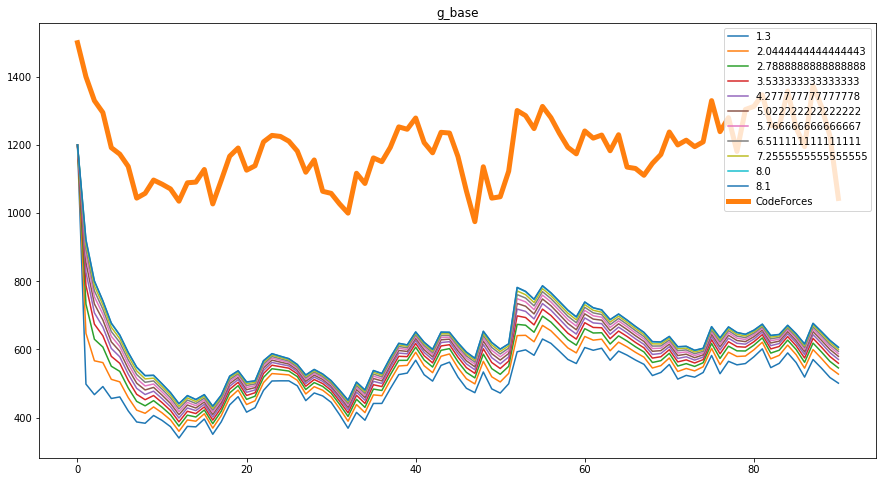

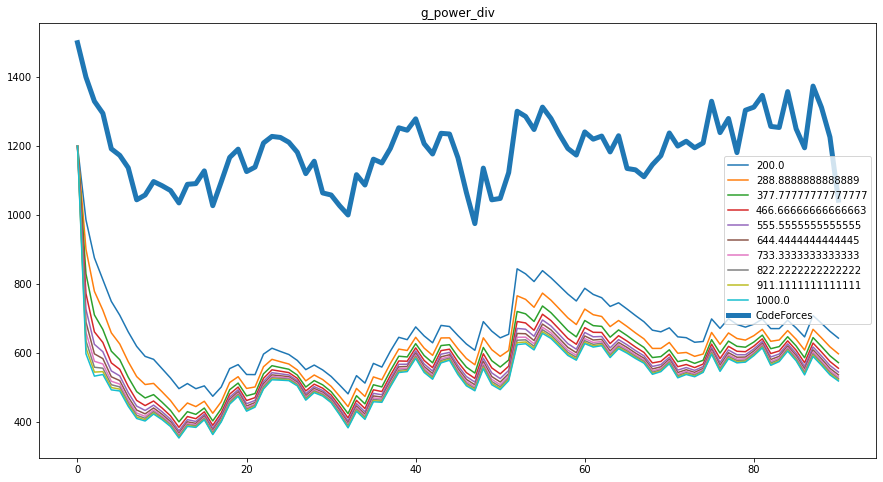

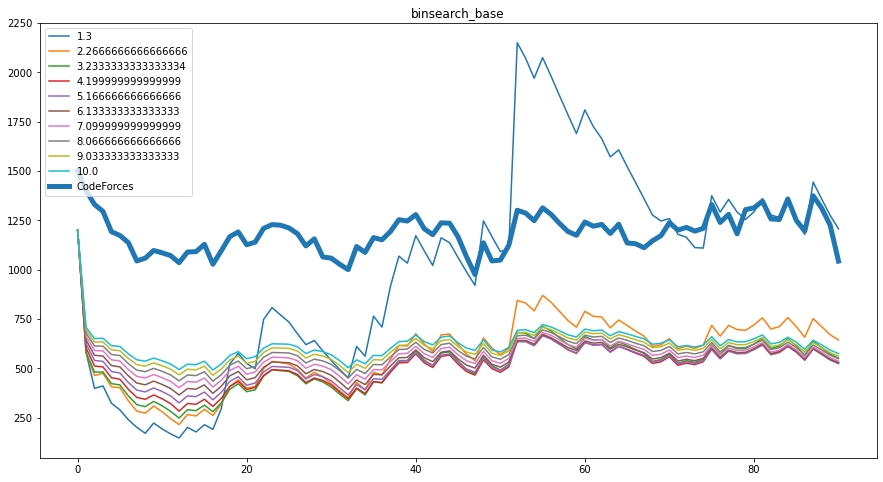

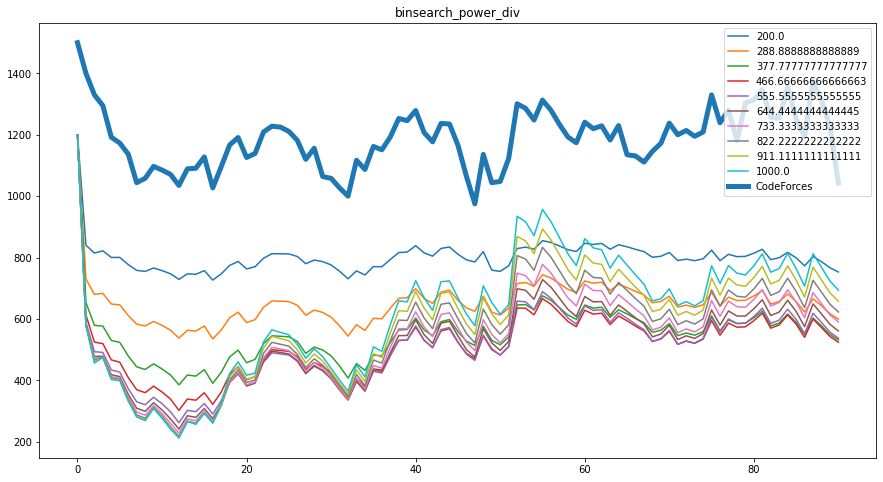

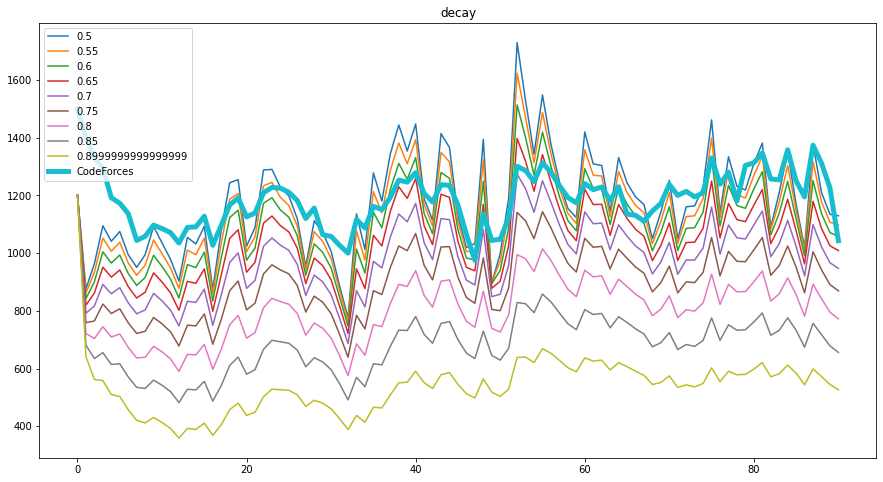

In [24]:
handle = all_results["g_base"][1.3][1].get_random_user(threshold=50)
for param_name, results in all_results.items():
    plt.figure(figsize=(15, 8))
    for value, (_, result) in results.items():
        xs, atcoder_ratings, cf_ratings = get_ratings(result, handle)
        plt.plot(xs, atcoder_ratings, label=str(value))
    plt.plot(xs, cf_ratings, label="CodeForces", linewidth=5)
    plt.title(param_name)
    plt.legend()
    plt.show()

### Save results

In [70]:
with open(save_file, "wb") as outfile:
    pickle.dump(all_results, outfile)

### Load results

In [30]:
with open(save_file, "rb") as infile:
    all_results = pickle.load(infile)

### Plot results

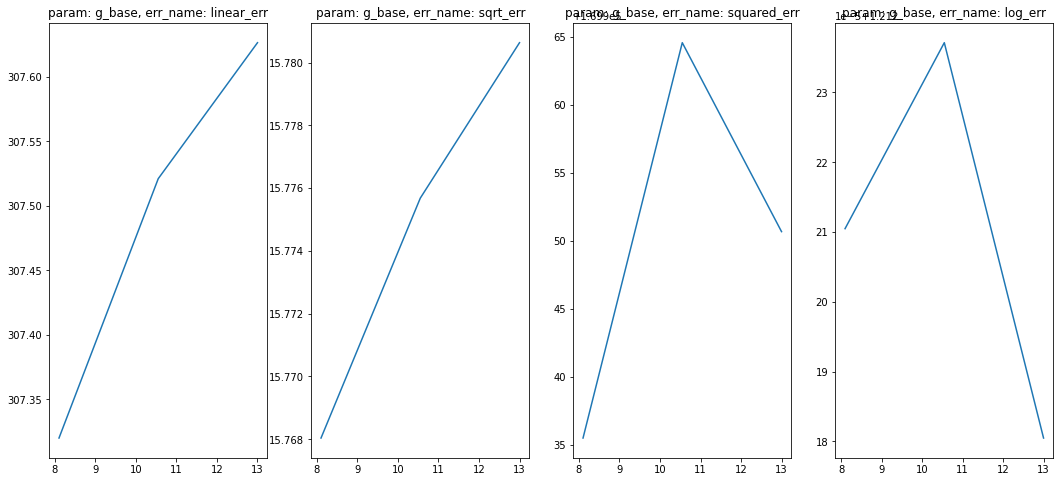

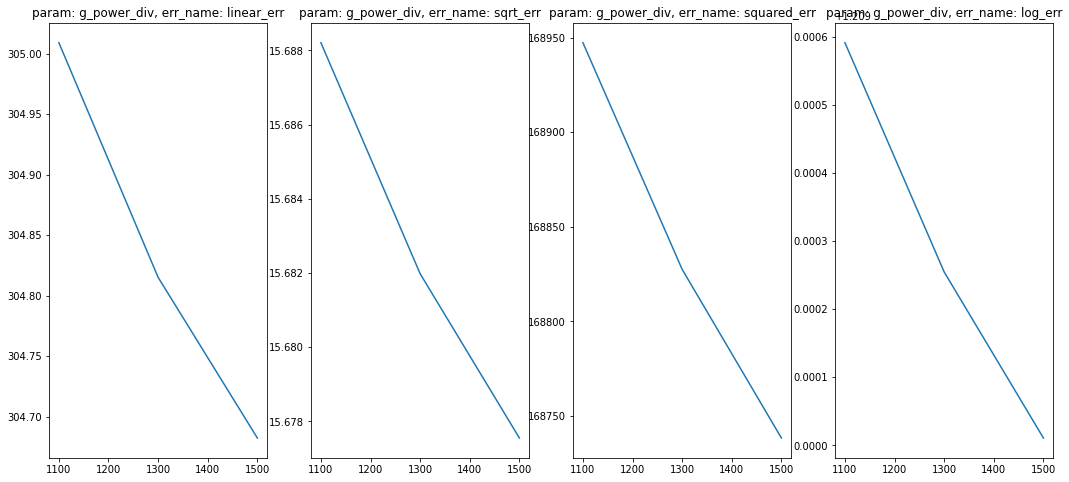

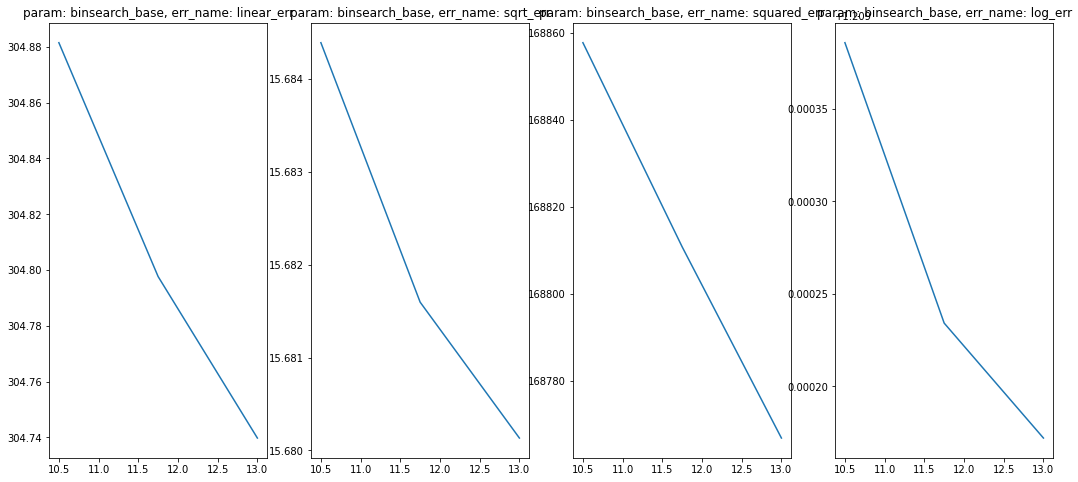

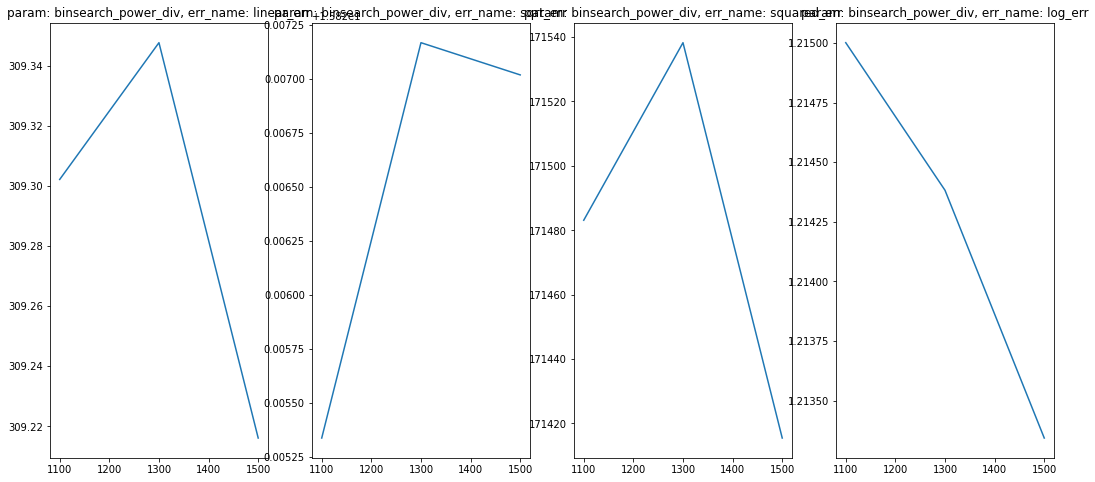

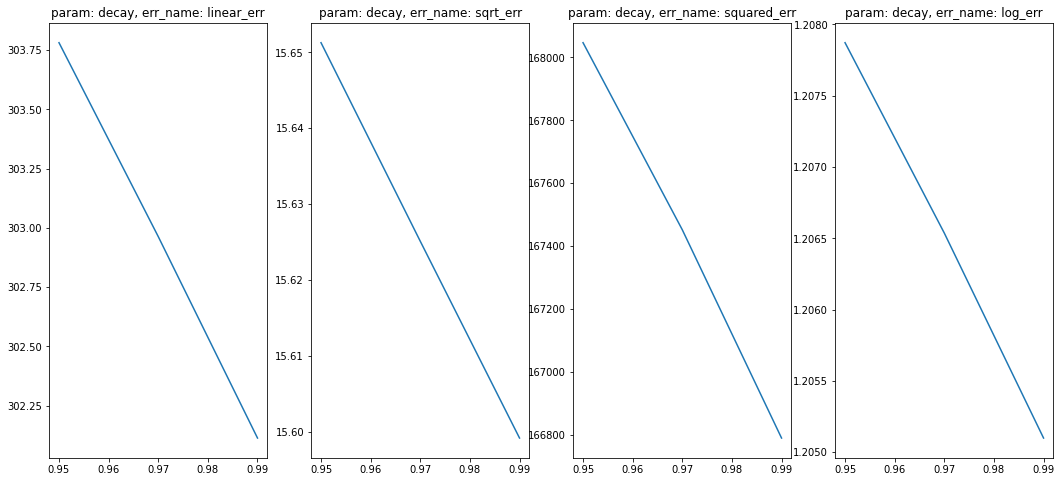

In [71]:
def get_ys(results, err_name):
    ys = []
    for val, all_errors in sorted(results.items(), key=lambda x: x[0]):
        errors = all_errors[err_name]
        vals = list(errors.values())
        ys.append(np.mean(vals))
    return ys
    
err_names = [err_f.__name__ for err_f in err_fun]
for param_name, results in all_results.items():
    fig, axs = plt.subplots(1, len(err_names), figsize=(18, 8))
    xs = sorted(list(results.keys()))
    for ax, err_name in zip(axs, err_names):
        ax.title.set_text(f"param: {param_name}, err_name: {err_name}")
        ys = get_ys(results, err_name)
        ax.plot(xs, ys)

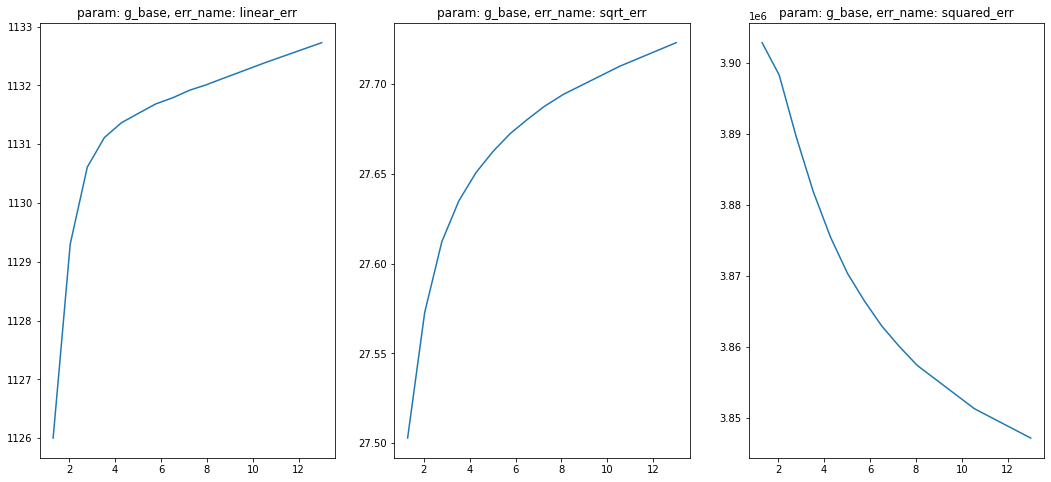

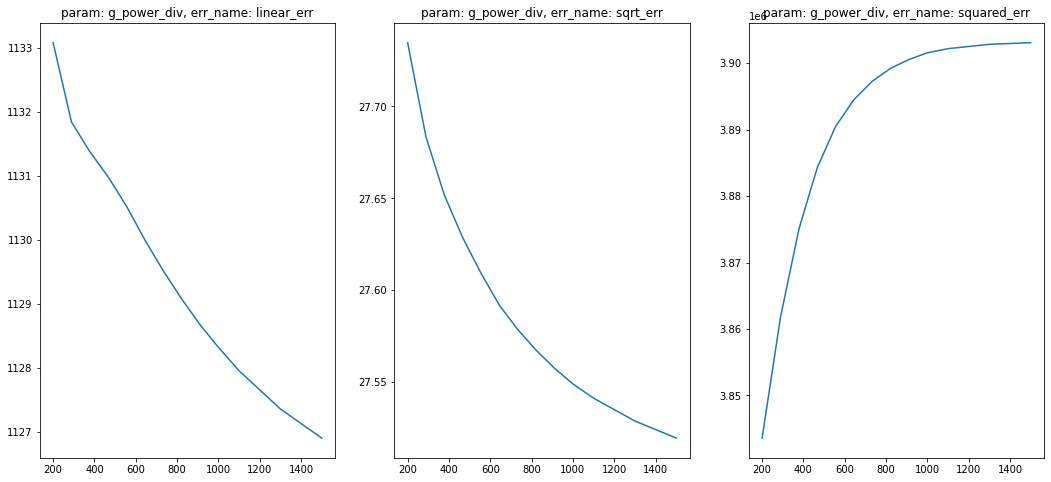

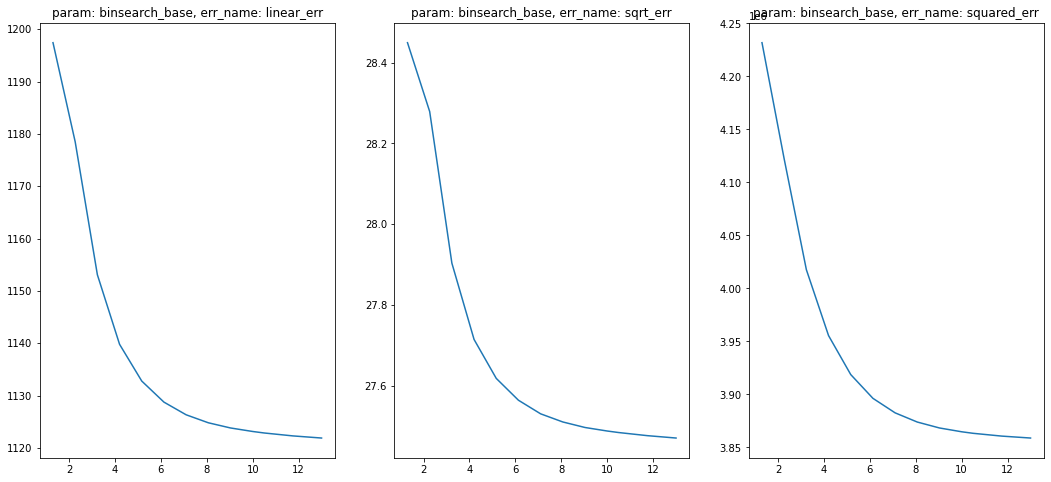

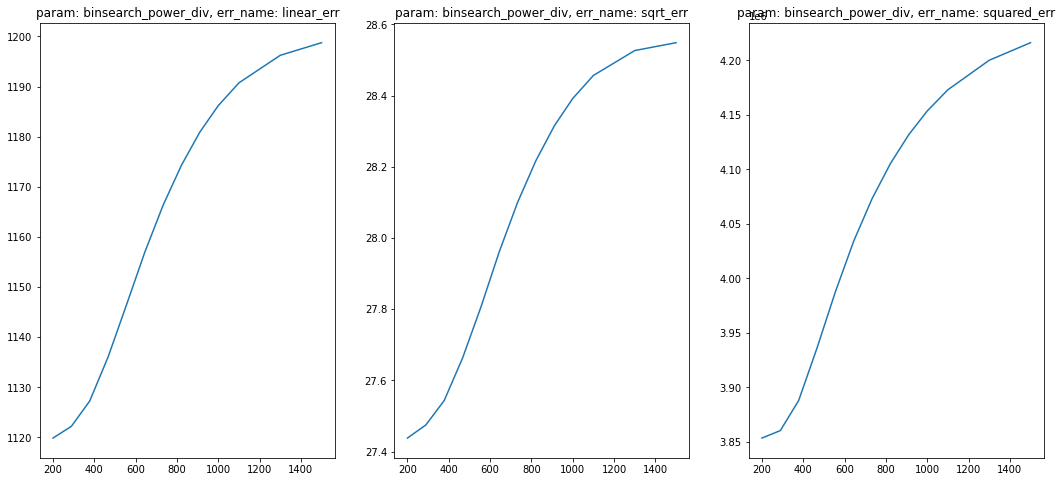

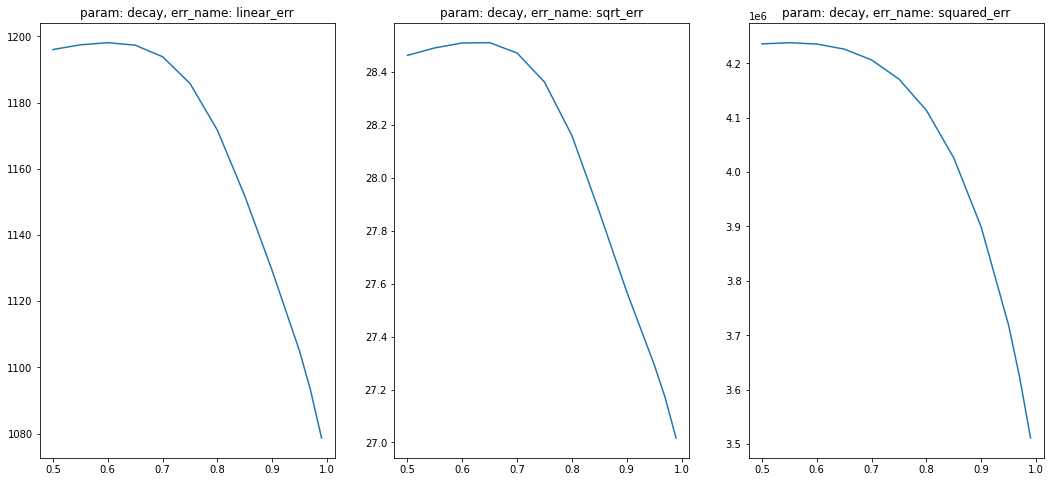

In [22]:
def get_ys(results, err_name):
    ys = []
    for val, (all_errors, _) in sorted(results.items(), key=lambda x: x[0]):
        errors = all_errors[err_name]
        vals = list(errors.values())
        ys.append(np.mean(vals))
    return ys
    
err_names = [err_f.__name__ for err_f in err_fun]
for param_name, results in all_results.items():
    fig, axs = plt.subplots(1, len(err_names), figsize=(18, 8))
    xs = sorted(list(results.keys()))
    for ax, err_name in zip(axs, err_names):
        ax.title.set_text(f"param: {param_name}, err_name: {err_name}")
        ys = get_ys(results, err_name)
        ax.plot(xs, ys)